## 1. Setup and Data Loading

In [130]:
# Import required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# Preprocessing and chemometrics
from scipy.signal import savgol_filter
from scipy import sparse
from scipy.sparse.linalg import spsolve

# Machine learning
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import (
    accuracy_score, classification_report, confusion_matrix,
    precision_recall_fscore_support
)

# Set plotting style
#plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
# Configure visualization style
plt.rcParams['figure.facecolor'] = 'white'
plt.rcParams['axes.facecolor'] = 'white'
plt.rcParams['axes.edgecolor'] = 'gray'
plt.rcParams['axes.linewidth'] = 1.0
plt.rcParams['grid.color'] = 'lightgray'
plt.rcParams['grid.linestyle'] = '--'
plt.rcParams['grid.linewidth'] = 0.5
plt.rcParams['grid.alpha'] = 0.3



In [131]:
# Load the preprocessed dataset
print("Loading datasets...")
print("="*80)

data_dir = Path('ml_datasets')

# Load transmittance data (main dataset with labels)
df_transmittance = pd.read_csv(data_dir / 'feature_matrix_raw_transmittance.csv')

print(f"Transmittance dataset: {df_transmittance.shape}")

# Display column structure
print("\nDataset columns:")
print(f"  Label columns: {[col for col in df_transmittance.columns if not col.replace('.', '').replace('-', '').isdigit()]}")
print(f"  Spectral columns: {len([col for col in df_transmittance.columns if col.replace('.', '').replace('-', '').isdigit()])} wavenumbers")

df_transmittance.head()


Loading datasets...
Transmittance dataset: (160, 3457)

Dataset columns:
  Label columns: ['Spectrum_ID', 'Sample_ID', 'Replica', 'Origin', 'Type', 'Subtype']
  Spectral columns: 3451 wavenumbers


,Spectrum_ID,Sample_ID,Replica,Origin,Type,Subtype,4000.0,3999.0,3998.0,3997.0,...,559.0,558.0,557.0,556.0,555.0,554.0,553.0,552.0,551.0,550.0
0,1,MTF_ACT_001,1,Man-made,Cellulose acetate,Cellulose Diacetate,101.04,101.04,101.03,101.03,...,86.31,86.63,86.68,86.26,85.63,85.27,85.35,85.74,86.31,87.00
1,2,MTF_ACT_002,1,Man-made,Cellulose acetate,Cellulose Triacetate,97.48,97.50,97.52,97.54,...,88.93,88.36,88.20,88.25,88.22,87.99,87.76,87.71,87.94,88.38
2,3,MTF_ACT_003,1,Man-made,Cellulose acetate,Cellulose Diacetate,98.17,98.19,98.21,98.23,...,77.91,78.01,78.04,77.78,77.43,77.43,77.97,78.97,80.17,81.23
3,4,MTF_ACT_004,1,Man-made,Cellulose acetate,Cellulose Diacetate,97.22,97.25,97.27,97.29,...,80.94,81.38,81.53,81.25,80.63,79.97,79.60,79.87,80.88,82.23
4,5,MTF_ACR_005,1,Man-made,Acrylic,PAN/MA,100.33,100.32,100.32,100.31,...,95.66,96.88,98.00,98.40,97.98,97.27,96.80,96.78,96.90,96.81


In [132]:
# Extract spectral data and labels
print("Extracting spectral data and labels...")
print("="*80)

# Identify label and spectral columns
label_cols = ['Spectrum_ID', 'Sample_ID', 'Replica', 'Origin', 'Type', 'Subtype']
spectral_cols = [col for col in df_transmittance.columns if col not in label_cols]

# Extract wavenumbers
wavenumbers = np.array([float(col) for col in spectral_cols])

# Extract transmittance spectra (%T)
transmittance_spectra = df_transmittance[spectral_cols].values

# Extract labels
sample_ids = df_transmittance['Sample_ID'].values
origins = df_transmittance['Origin'].values  # Natural/Man-made
types = df_transmittance['Type'].values      # Cellulose, Protein, Polyester, etc.
subtypes = df_transmittance['Subtype'].values  # Cotton, Silk, PET, etc.

print(f"Number of samples: {len(transmittance_spectra)}")
print(f"Number of wavenumbers: {len(wavenumbers)}")
print(f"Wavenumber range: {wavenumbers.min():.1f} - {wavenumbers.max():.1f} cm⁻¹")
print(f"\nOrigins: {np.unique(origins)}")
print(f"Number of Types: {len(np.unique(types))}")
print(f"Number of Subtypes: {len(np.unique(subtypes))}")

# Display sample distribution
print("\nSample distribution by Origin:")
for origin in np.unique(origins):
    count = np.sum(origins == origin)
    print(f"  {origin}: {count} samples ({count/len(origins)*100:.1f}%)")

print("\nSample distribution by Type:")
for ftype in sorted(np.unique(types)):
    count = np.sum(types == ftype)
    print(f"  {ftype}: {count} samples ({count/len(types)*100:.1f}%)")


Extracting spectral data and labels...
Number of samples: 160
Number of wavenumbers: 3451
Wavenumber range: 550.0 - 4000.0 cm⁻¹

Origins: ['Man-made' 'Natural']
Number of Types: 10
Number of Subtypes: 31

Sample distribution by Origin:
  Man-made: 102 samples (63.7%)
  Natural: 58 samples (36.2%)

Sample distribution by Type:
  Acrylic: 14 samples (8.8%)
  Aramid: 4 samples (2.5%)
  Cellulose: 22 samples (13.8%)
  Cellulose acetate: 4 samples (2.5%)
  Modacrylic: 18 samples (11.2%)
  Polyamide: 18 samples (11.2%)
  Polyester: 17 samples (10.6%)
  Polyolefin: 8 samples (5.0%)
  Protein: 36 samples (22.5%)
  Regenerated cellulose: 19 samples (11.9%)


## 2. Preprocessing Functions

In [133]:
def transmittance_to_absorbance(transmittance):
    """
    Convert transmittance (%T) to absorbance (A).
    
    Formula: A = -log10(T/100)
    where T is transmittance in percentage (0-100)
    
    Parameters:
    -----------
    transmittance : array-like
        Transmittance values in percentage (0-100)
    
    Returns:
    --------
    absorbance : array-like
        Absorbance values
    """
    # Handle edge cases: T=0 would give inf, T>100 is invalid
    T_clipped = np.clip(transmittance, 0.001, 100.0)  # Avoid log(0)
    absorbance = -np.log10(T_clipped / 100.0)
    return absorbance


def als_baseline_correction(spectrum, lam=1e6, p=0.001, niter=10):
    """
    Asymmetric Least Squares (ALS) baseline correction.
    
    Parameters:
    -----------
    spectrum : array-like
        Input spectrum (absorbance)
    lam : float
        Smoothness parameter (typically 10^2 to 10^9)
    p : float
        Asymmetry parameter (typically 0.001 to 0.1)
    niter : int
        Number of iterations
    
    Returns:
    --------
    baseline : array-like
        Estimated baseline
    
    Reference:
    ----------
    Eilers & Boelens (2005). Baseline correction with asymmetric least squares smoothing.
    """
    L = len(spectrum)
    D = sparse.diags([1, -2, 1], [0, 1, 2], shape=(L-2, L))
    w = np.ones(L)
    
    for i in range(niter):
        W = sparse.spdiags(w, 0, L, L)
        Z = W + lam * D.T.dot(D)
        z = spsolve(Z, w * spectrum)
        w = p * (spectrum > z) + (1 - p) * (spectrum < z)
        
    return z


def standard_normal_variate(spectrum):
    """
    Standard Normal Variate (SNV) transformation.
    
    Removes multiplicative scatter effects by standardizing each spectrum
    to zero mean and unit variance.
    
    Parameters:
    -----------
    spectrum : array-like
        Input spectrum
    
    Returns:
    --------
    snv_spectrum : array-like
        SNV-transformed spectrum
    
    Reference:
    ----------
    Barnes et al. (1989). Standard normal variate transformation and 
    de-trending of near-infrared diffuse reflectance spectra.
    """
    mean = np.mean(spectrum)
    std = np.std(spectrum)
    
    if std == 0:
        return spectrum - mean
    
    return (spectrum - mean) / std



## 3. Pipeline Generation

Generate four preprocessing pipelines:
- **P1**: ALS + SNV (baseline + scatter correction)
- **P2**: ALS + SNV + D1 (baseline + scatter + 1st derivative)
- **P3**: SNV + D1 (scatter + 1st derivative, no baseline)
- **P4**: ALS + SNV + D2 (baseline + scatter + 2nd derivative)

In [134]:
print("Generating preprocessing pipelines...")
print("="*80)

# Step 1: Convert transmittance to absorbance
print("Step 1: Converting transmittance to absorbance...")
absorbance_spectra = np.zeros_like(transmittance_spectra)
for i in range(len(transmittance_spectra)):
    absorbance_spectra[i] = transmittance_to_absorbance(transmittance_spectra[i])

print(f"  Converted {len(absorbance_spectra)} spectra")
print(f"  Absorbance range: {absorbance_spectra.min():.3f} to {absorbance_spectra.max():.3f}")

# Step 2: Apply ALS baseline correction
print("\nStep 2: Applying ALS baseline correction...")
als_corrected_absorbance = np.zeros_like(absorbance_spectra)
for i in range(len(absorbance_spectra)):
    baseline = als_baseline_correction(absorbance_spectra[i], lam=1e6, p=0.001, niter=10)
    als_corrected_absorbance[i] = absorbance_spectra[i] - baseline
    
    if (i + 1) % 10 == 0:
        print(f"  Processed {i + 1}/{len(absorbance_spectra)} spectra...")

print(f"  ALS baseline correction complete")
print(f"  Absorbance range after ALS: {als_corrected_absorbance.min():.3f} to {als_corrected_absorbance.max():.3f}")


Generating preprocessing pipelines...
Step 1: Converting transmittance to absorbance...
  Converted 160 spectra
  Absorbance range: -0.000 to 0.548

Step 2: Applying ALS baseline correction...
  Processed 10/160 spectra...
  Processed 20/160 spectra...
  Processed 30/160 spectra...
  Processed 40/160 spectra...
  Processed 50/160 spectra...
  Processed 60/160 spectra...
  Processed 70/160 spectra...
  Processed 80/160 spectra...
  Processed 90/160 spectra...
  Processed 100/160 spectra...
  Processed 110/160 spectra...
  Processed 120/160 spectra...
  Processed 130/160 spectra...
  Processed 140/160 spectra...
  Processed 150/160 spectra...
  Processed 160/160 spectra...
  ALS baseline correction complete
  Absorbance range after ALS: -0.004 to 0.511


In [135]:
# Pipeline 1: ALS + SNV
print("\nGenerating Pipeline 1: ALS + SNV")
print("-"*80)

pipeline_1_data = np.zeros_like(als_corrected_absorbance)
for i in range(len(als_corrected_absorbance)):
    pipeline_1_data[i] = standard_normal_variate(als_corrected_absorbance[i])

print(f"  Applied SNV to {len(pipeline_1_data)} spectra")
print(f"  -- Mean: {pipeline_1_data.mean():.6f} (should be ~0)")
print(f"  -- Std: {pipeline_1_data.std():.6f}")
print(f"  -- Range: {pipeline_1_data.min():.3f} to {pipeline_1_data.max():.3f}")


Generating Pipeline 1: ALS + SNV
--------------------------------------------------------------------------------
  Applied SNV to 160 spectra
  -- Mean: 0.000000 (should be ~0)
  -- Std: 1.000000
  -- Range: -1.228 to 21.132


In [136]:
# Pipeline 2: ALS + SNV + D1 (Savitzky-Golay 1st derivative)
print("\nGenerating Pipeline 2: ALS + SNV + D1")
print("-"*80)

# Savitzky-Golay parameters (literature standard)
window_length = 15  # Must be odd
polyorder = 3       # Polynomial order
deriv = 1           # 1st derivative

pipeline_2_data = np.zeros_like(pipeline_1_data)
for i in range(len(pipeline_1_data)):
    pipeline_2_data[i] = savgol_filter(
        pipeline_1_data[i], 
        window_length=window_length, 
        polyorder=polyorder, 
        deriv=deriv
    )

print(f"  Applied Savitzky-Golay 1st derivative")
print(f"  Parameters: window_length={window_length}, polyorder={polyorder}, deriv={deriv}")
print(f"  Mean: {pipeline_2_data.mean():.6f}")
print(f"  Std: {pipeline_2_data.std():.6f}")
print(f"  Range: {pipeline_2_data.min():.3f} to {pipeline_2_data.max():.3f}")


Generating Pipeline 2: ALS + SNV + D1
--------------------------------------------------------------------------------
  Applied Savitzky-Golay 1st derivative
  Parameters: window_length=15, polyorder=3, deriv=1
  Mean: 0.000501
  Std: 0.051823
  Range: -4.808 to 3.327


In [137]:
# Pipeline 3: SNV + D1 (No ALS baseline correction)
print("\nGenerating Pipeline 3: SNV + D1")
print("-"*80)

# Apply SNV to raw absorbance (without ALS)
snv_raw = np.zeros_like(absorbance_spectra)
for i in range(len(absorbance_spectra)):
    snv_raw[i] = standard_normal_variate(absorbance_spectra[i])

# Apply Savitzky-Golay 1st derivative
pipeline_3_data = np.zeros_like(snv_raw)
for i in range(len(snv_raw)):
    pipeline_3_data[i] = savgol_filter(
        snv_raw[i], 
        window_length=window_length, 
        polyorder=polyorder, 
        deriv=deriv
    )

print(f"  Applied SNV (without ALS) + Savitzky-Golay 1st derivative")
print(f"  Mean: {pipeline_3_data.mean():.6f}")
print(f"  Std: {pipeline_3_data.std():.6f}")
print(f"  Range: {pipeline_3_data.min():.3f} to {pipeline_3_data.max():.3f}")


Generating Pipeline 3: SNV + D1
--------------------------------------------------------------------------------
  Applied SNV (without ALS) + Savitzky-Golay 1st derivative
  Mean: 0.000915
  Std: 0.038864
  Range: -4.804 to 2.970


In [138]:
# Pipeline 4: ALS + SNV + D2 (Savitzky-Golay 2nd derivative)
print("\nGenerating Pipeline 4: ALS + SNV + D2")
print("-"*80)

deriv_2 = 2  # 2nd derivative

pipeline_4_data = np.zeros_like(pipeline_1_data)
for i in range(len(pipeline_1_data)):
    pipeline_4_data[i] = savgol_filter(
        pipeline_1_data[i], 
        window_length=window_length, 
        polyorder=polyorder, 
        deriv=deriv_2
    )

print(f"  Applied Savitzky-Golay 2nd derivative")
print(f"  Parameters: window_length={window_length}, polyorder={polyorder}, deriv={deriv_2}")
print(f"  Mean: {pipeline_4_data.mean():.6f}")
print(f"  Std: {pipeline_4_data.std():.6f}")
print(f"  Range: {pipeline_4_data.min():.3f} to {pipeline_4_data.max():.3f}")



Generating Pipeline 4: ALS + SNV + D2
--------------------------------------------------------------------------------
  Applied Savitzky-Golay 2nd derivative
  Parameters: window_length=15, polyorder=3, deriv=2
  Mean: -0.000021
  Std: 0.010194
  Range: -1.670 to 0.907


## 4. Visualization of Preprocessing Effects

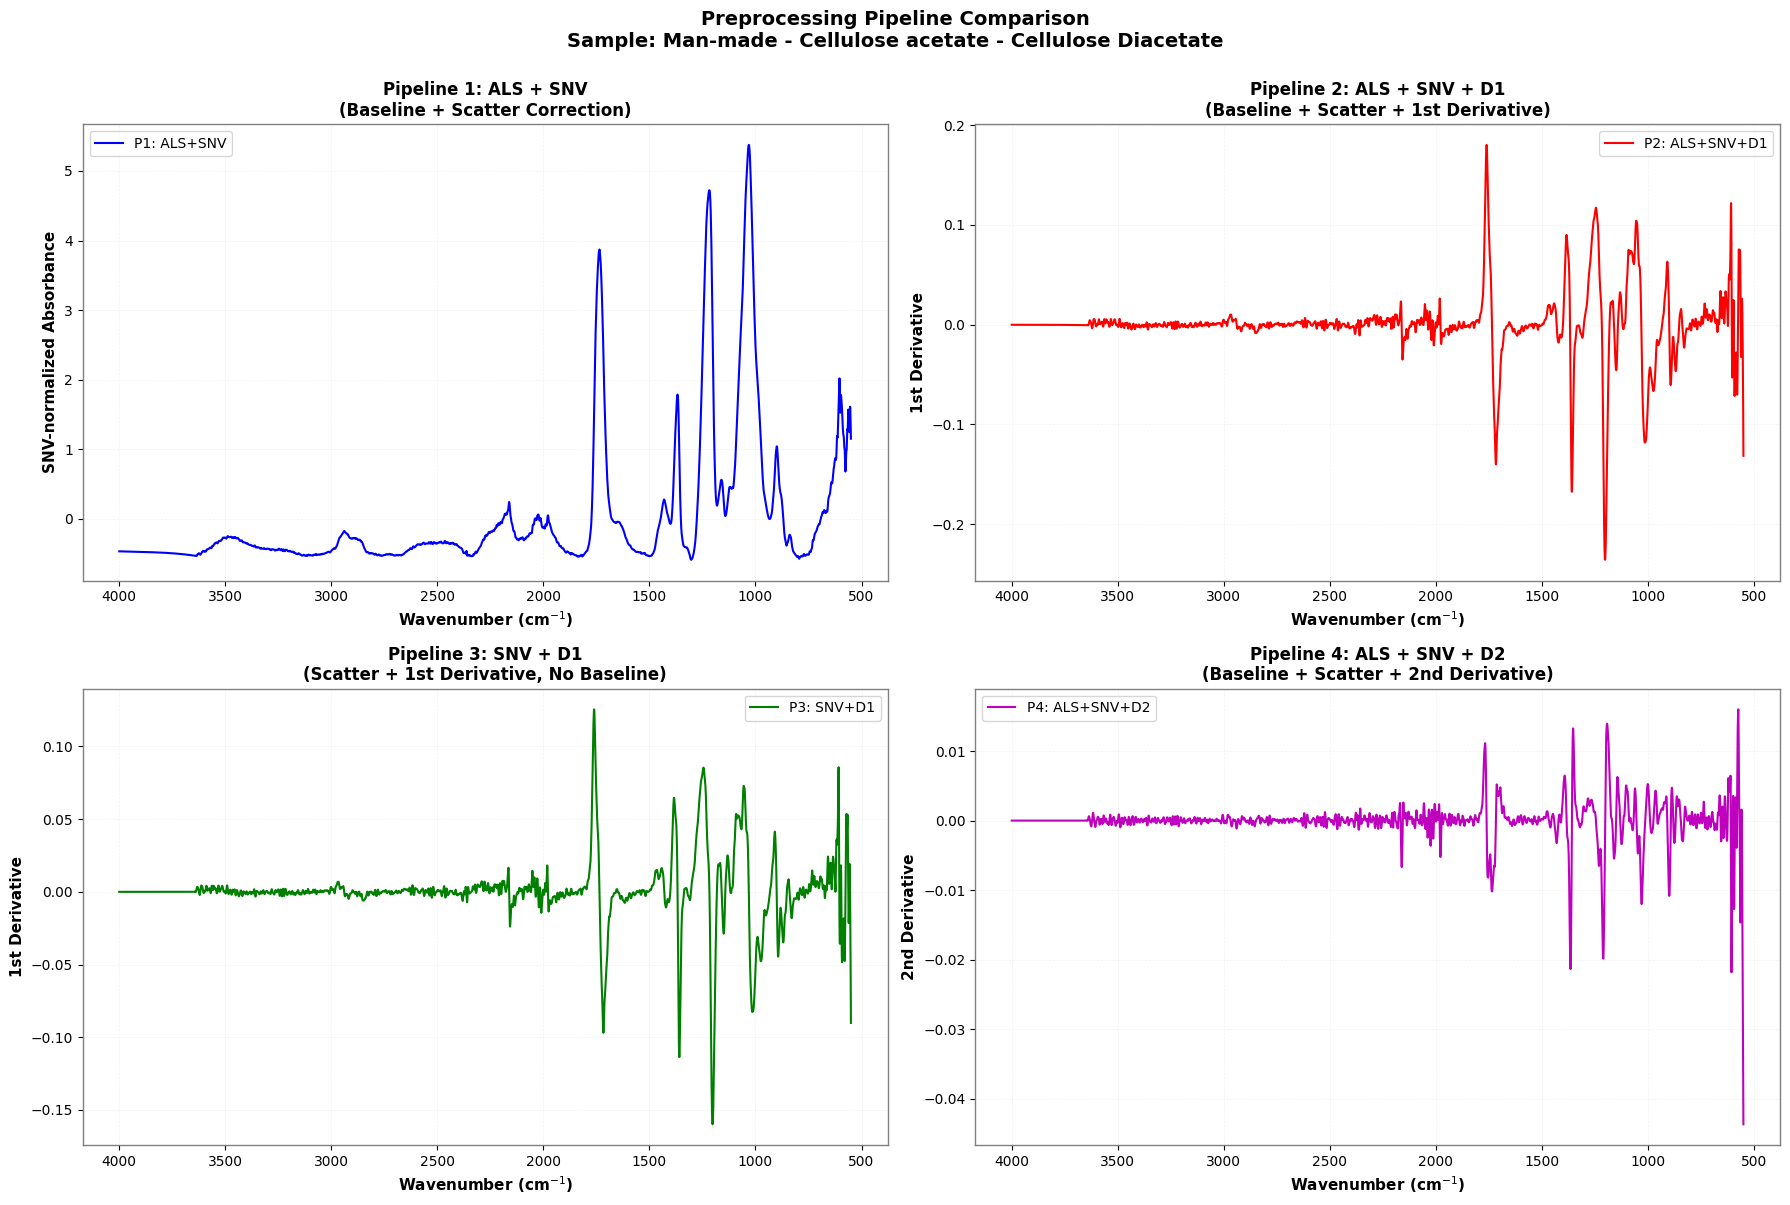

Displayed preprocessing effects for sample: Man-made - Cellulose acetate - Cellulose Diacetate


In [139]:
# Visualize preprocessing effects on a representative sample
sample_idx = 0  # First sample
sample_name = f"{origins[sample_idx]} - {types[sample_idx]} - {subtypes[sample_idx]}"

fig, axes = plt.subplots(2, 2, figsize=(18, 12))

# Pipeline 1: ALS + SNV
axes[0, 0].plot(wavenumbers, pipeline_1_data[sample_idx], 'b-', linewidth=1.5, label='P1: ALS+SNV')
axes[0, 0].set_title('Pipeline 1: ALS + SNV\n(Baseline + Scatter Correction)', 
                    fontsize=12, fontweight='bold')
axes[0, 0].set_xlabel(r'Wavenumber (cm$^{-1}$)', fontsize=11, fontweight='bold')
axes[0, 0].set_ylabel('SNV-normalized Absorbance', fontsize=11, fontweight='bold')
axes[0, 0].invert_xaxis()
axes[0, 0].grid(True, alpha=0.3)
axes[0, 0].legend()

# Pipeline 2: ALS + SNV + D1
axes[0, 1].plot(wavenumbers, pipeline_2_data[sample_idx], 'r-', linewidth=1.5, label='P2: ALS+SNV+D1')
axes[0, 1].set_title('Pipeline 2: ALS + SNV + D1\n(Baseline + Scatter + 1st Derivative)', 
                    fontsize=12, fontweight='bold')
axes[0, 1].set_xlabel(r'Wavenumber (cm$^{-1}$)', fontsize=11, fontweight='bold')
axes[0, 1].set_ylabel('1st Derivative', fontsize=11, fontweight='bold')
axes[0, 1].invert_xaxis()
axes[0, 1].grid(True, alpha=0.3)
axes[0, 1].legend()

# Pipeline 3: SNV + D1
axes[1, 0].plot(wavenumbers, pipeline_3_data[sample_idx], 'g-', linewidth=1.5, label='P3: SNV+D1')
axes[1, 0].set_title('Pipeline 3: SNV + D1\n(Scatter + 1st Derivative, No Baseline)', 
                    fontsize=12, fontweight='bold')
axes[1, 0].set_xlabel(r'Wavenumber (cm$^{-1}$)', fontsize=11, fontweight='bold')
axes[1, 0].set_ylabel('1st Derivative', fontsize=11, fontweight='bold')
axes[1, 0].invert_xaxis()
axes[1, 0].grid(True, alpha=0.3)
axes[1, 0].legend()

# Pipeline 4: ALS + SNV + D2
axes[1, 1].plot(wavenumbers, pipeline_4_data[sample_idx], 'm-', linewidth=1.5, label='P4: ALS+SNV+D2')
axes[1, 1].set_title('Pipeline 4: ALS + SNV + D2\n(Baseline + Scatter + 2nd Derivative)', 
                    fontsize=12, fontweight='bold')
axes[1, 1].set_xlabel(r'Wavenumber (cm$^{-1}$)', fontsize=11, fontweight='bold')
axes[1, 1].set_ylabel('2nd Derivative', fontsize=11, fontweight='bold')
axes[1, 1].invert_xaxis()
axes[1, 1].grid(True, alpha=0.3)
axes[1, 1].legend()

plt.suptitle(f'Preprocessing Pipeline Comparison\nSample: {sample_name}', 
             fontsize=14, fontweight='bold', y=1.00)
plt.tight_layout()
plt.show()

print(f"Displayed preprocessing effects for sample: {sample_name}")

## 5. Principal Component Analysis (PCA)

In [140]:
# Apply PCA to all pipelines
print("Applying PCA to all pipelines...")
print("="*80)

n_components = 10  # Retain 10 principal components

# Pipeline 1: ALS + SNV
pca_p1 = PCA(n_components=n_components, random_state=42)
X_pca_p1 = pca_p1.fit_transform(pipeline_1_data)

# Pipeline 2: ALS + SNV + D1
pca_p2 = PCA(n_components=n_components, random_state=42)
X_pca_p2 = pca_p2.fit_transform(pipeline_2_data)

# Pipeline 3: SNV + D1
pca_p3 = PCA(n_components=n_components, random_state=42)
X_pca_p3 = pca_p3.fit_transform(pipeline_3_data)

# Pipeline 4: ALS + SNV + D2
pca_p4 = PCA(n_components=n_components, random_state=42)
X_pca_p4 = pca_p4.fit_transform(pipeline_4_data)

print(f"PCA applied: {n_components} components retained")
print(f"\nVariance explained (total):")
print(f"  P1 (ALS+SNV):     {pca_p1.explained_variance_ratio_.sum()*100:.2f}%")
print(f"  P2 (ALS+SNV+D1):  {pca_p2.explained_variance_ratio_.sum()*100:.2f}%")
print(f"  P3 (SNV+D1):      {pca_p3.explained_variance_ratio_.sum()*100:.2f}%")
print(f"  P4 (ALS+SNV+D2):  {pca_p4.explained_variance_ratio_.sum()*100:.2f}%")

print(f"\nPC1+PC2 variance:")
print(f"  P1 (ALS+SNV):     {pca_p1.explained_variance_ratio_[:2].sum()*100:.2f}%")
print(f"  P2 (ALS+SNV+D1):  {pca_p2.explained_variance_ratio_[:2].sum()*100:.2f}%")
print(f"  P3 (SNV+D1):      {pca_p3.explained_variance_ratio_[:2].sum()*100:.2f}%")
print(f"  P4 (ALS+SNV+D2):  {pca_p4.explained_variance_ratio_[:2].sum()*100:.2f}%")

Applying PCA to all pipelines...
PCA applied: 10 components retained

Variance explained (total):
  P1 (ALS+SNV):     91.94%
  P2 (ALS+SNV+D1):  78.48%
  P3 (SNV+D1):      83.92%
  P4 (ALS+SNV+D2):  87.76%

PC1+PC2 variance:
  P1 (ALS+SNV):     57.59%
  P2 (ALS+SNV+D1):  31.08%
  P3 (SNV+D1):      39.38%
  P4 (ALS+SNV+D2):  58.70%


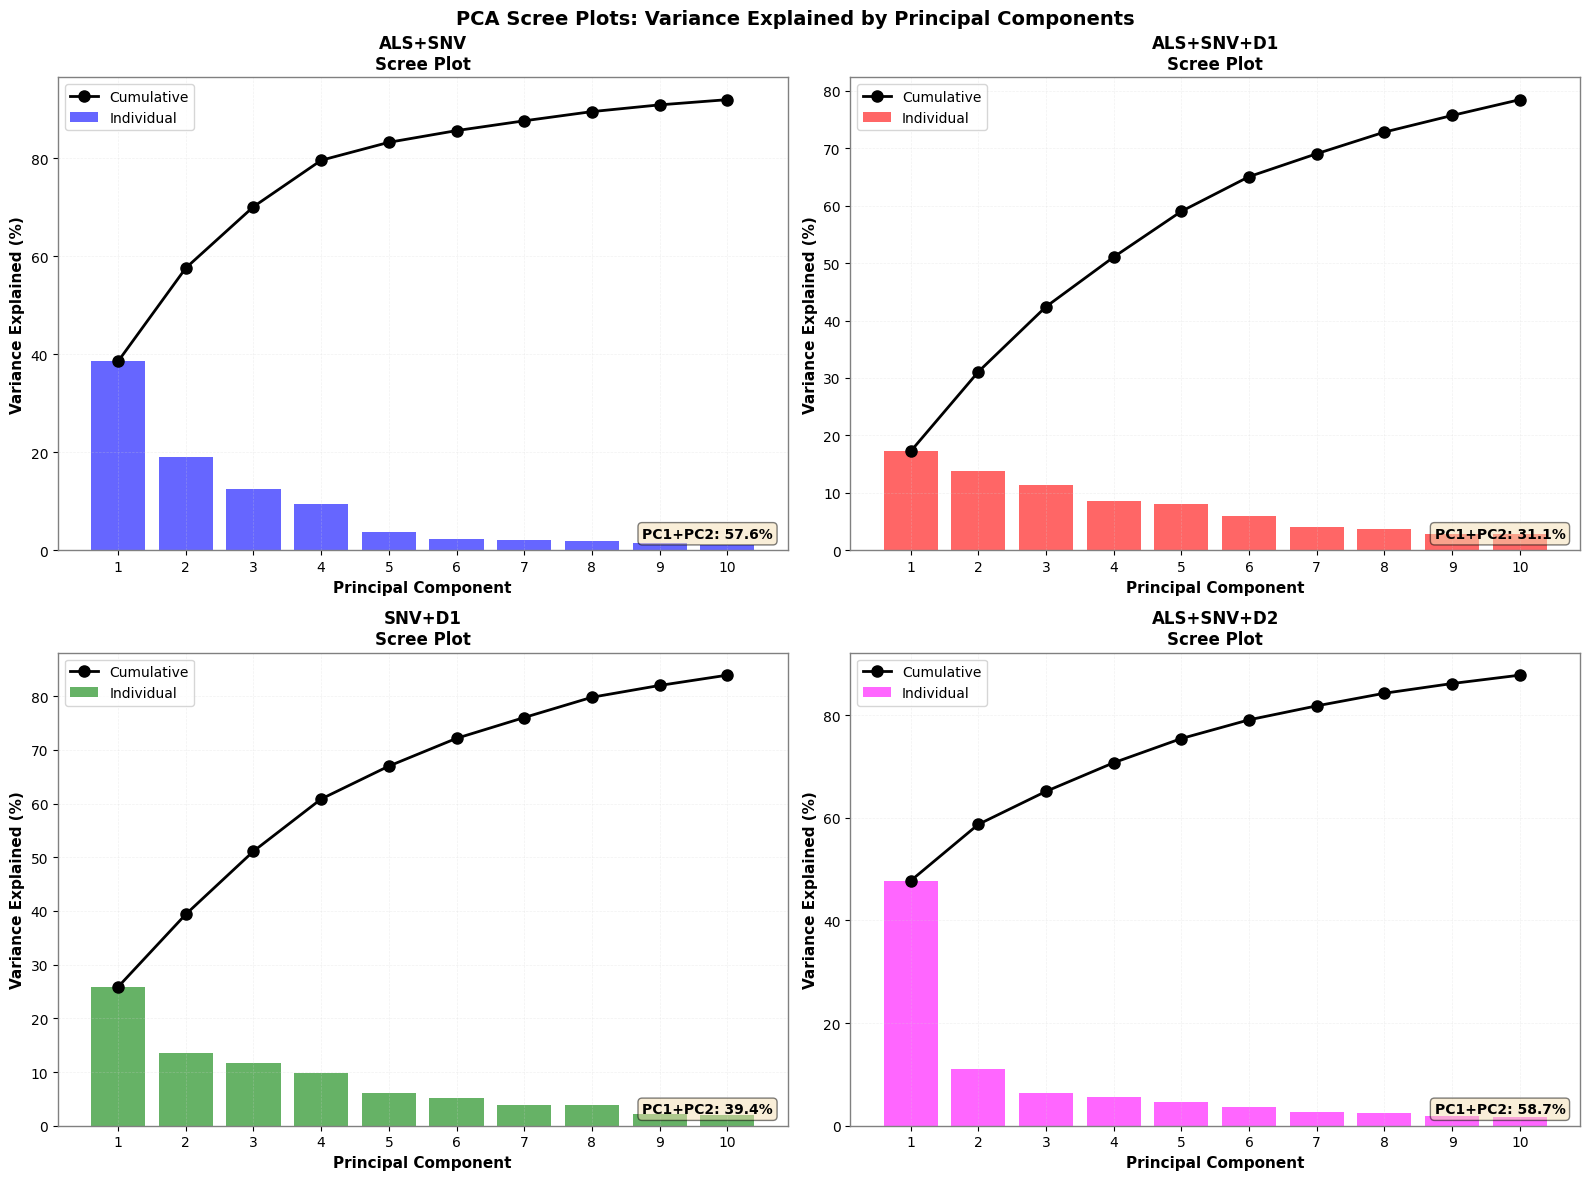

Scree plots displayed for all 4 pipelines


In [141]:
# Scree plots for all pipelines
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

pca_objects = [pca_p1, pca_p2, pca_p3, pca_p4]
pipeline_names = ['ALS+SNV', 'ALS+SNV+D1', 'SNV+D1', 'ALS+SNV+D2']
colors = ['blue', 'red', 'green', 'magenta']

for idx, (pca_obj, name, color) in enumerate(zip(pca_objects, pipeline_names, colors)):
    ax = axes[idx // 2, idx % 2]
    
    # Individual variance
    ax.bar(range(1, n_components + 1), 
           pca_obj.explained_variance_ratio_ * 100,
           alpha=0.6, color=color, label='Individual')
    
    # Cumulative variance
    ax.plot(range(1, n_components + 1), 
            np.cumsum(pca_obj.explained_variance_ratio_) * 100,
            'ko-', linewidth=2, markersize=8, label='Cumulative')
    
    ax.set_xlabel('Principal Component', fontsize=11, fontweight='bold')
    ax.set_ylabel('Variance Explained (%)', fontsize=11, fontweight='bold')
    ax.set_title(f'{name}\nScree Plot', fontsize=12, fontweight='bold')
    ax.set_xticks(range(1, n_components + 1))
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    # Add PC1+PC2 annotation
    pc12_var = pca_obj.explained_variance_ratio_[:2].sum() * 100
    ax.text(0.98, 0.02, f'PC1+PC2: {pc12_var:.1f}%',
            transform=ax.transAxes, fontsize=10, fontweight='bold',
            verticalalignment='bottom', horizontalalignment='right',
            bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

plt.suptitle('PCA Scree Plots: Variance Explained by Principal Components', 
             fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

print("Scree plots displayed for all 4 pipelines")

## 6. Classification: Support Vector Machine (SVM)

In [142]:
# Prepare classification tasks
print("Preparing classification tasks...")
print("="*80)

# Binary classification: Origin (Natural vs Man-made)
y_binary = origins

# Multi-class classification: Subtype (finest granularity)
y_multiclass = subtypes

print(f"Binary classification (Origin):")
print(f"  Classes: {np.unique(y_binary)}")
print(f"  Distribution: {[(c, np.sum(y_binary==c)) for c in np.unique(y_binary)]}")

print(f"\nMulti-class classification (Subtype):")
print(f"  Number of classes: {len(np.unique(y_multiclass))}")
print(f"  Classes: {sorted(np.unique(y_multiclass))}")

Preparing classification tasks...
Binary classification (Origin):
  Classes: ['Man-made' 'Natural']
  Distribution: [('Man-made', np.int64(102)), ('Natural', np.int64(58))]

Multi-class classification (Subtype):
  Number of classes: 31
  Classes: ['Alpaca', 'Cellulose Diacetate', 'Cellulose Triacetate', 'Cotton', 'Jute', 'Linen', 'Lyocell', 'Meta-Aramid', 'Modal', 'PA 6', 'PA 6,6', 'PAN/AA/MA', 'PAN/MA', 'PAN/MMA/MA', 'PAN/VA', 'PAN/VA/VC', 'PAN/VBr', 'PAN/VC', 'PAN/VDC', 'PE', 'PET', 'PP', 'Para-Aramid', 'Silk', 'Unspecified Aramid Type', 'Unspecified PA Copolymer', 'Unspecified PAN (Acrylic) Copolymer', 'Unspecified PAN (Modacrylic) Copolymer', 'Unspecified Regenerated Cellulose Polymer', 'Viscose', 'Wool']


In [143]:
# Train SVM classifiers for all pipelines
print("Training SVM classifiers (RBF kernel, C=10)...")
print("="*80)

# SVM configuration
svm_config = {
    'kernel': 'rbf',
    'C': 10,
    'gamma': 'scale',
    'random_state': 42
}

# Store results
svm_results = {
    'pipeline': [],
    'binary_cv_mean': [],
    'binary_cv_std': [],
    'multiclass_cv_mean': [],
    'multiclass_cv_std': []
}

# Iterate through pipelines
X_pca_list = [X_pca_p1, X_pca_p2, X_pca_p3, X_pca_p4]

for idx, (X_pca, name) in enumerate(zip(X_pca_list, pipeline_names)):
    print(f"\n{name}:")
    print("-" * 80)
    
    # Binary classification
    svm_binary = SVC(**svm_config)
    cv_scores_binary = cross_val_score(
        svm_binary, X_pca, y_binary, 
        cv=5, scoring='accuracy', n_jobs=-1
    )
    
    print(f"  Binary (Origin):")
    print(f"    CV Accuracy: {cv_scores_binary.mean()*100:.2f}% (+/- {cv_scores_binary.std()*100:.2f}%)")
    
    # Multi-class classification
    svm_multiclass = SVC(**svm_config)
    cv_scores_multiclass = cross_val_score(
        svm_multiclass, X_pca, y_multiclass, 
        cv=5, scoring='accuracy', n_jobs=-1
    )
    
    print(f"  Multi-class (Subtype):")
    print(f"    CV Accuracy: {cv_scores_multiclass.mean()*100:.2f}% (+/- {cv_scores_multiclass.std()*100:.2f}%)")
    
    # Store results
    svm_results['pipeline'].append(name)
    svm_results['binary_cv_mean'].append(cv_scores_binary.mean() * 100)
    svm_results['binary_cv_std'].append(cv_scores_binary.std() * 100)
    svm_results['multiclass_cv_mean'].append(cv_scores_multiclass.mean() * 100)
    svm_results['multiclass_cv_std'].append(cv_scores_multiclass.std() * 100)

Training SVM classifiers (RBF kernel, C=10)...

ALS+SNV:
--------------------------------------------------------------------------------
  Binary (Origin):
    CV Accuracy: 93.12% (+/- 6.37%)
  Multi-class (Subtype):
    CV Accuracy: 70.62% (+/- 1.53%)

ALS+SNV+D1:
--------------------------------------------------------------------------------
  Binary (Origin):
    CV Accuracy: 86.25% (+/- 8.75%)
  Multi-class (Subtype):
    CV Accuracy: 62.50% (+/- 7.13%)

SNV+D1:
--------------------------------------------------------------------------------
  Binary (Origin):
    CV Accuracy: 70.00% (+/- 15.39%)
  Multi-class (Subtype):
    CV Accuracy: 56.88% (+/- 5.00%)

ALS+SNV+D2:
--------------------------------------------------------------------------------
  Binary (Origin):
    CV Accuracy: 72.50% (+/- 12.25%)
  Multi-class (Subtype):
    CV Accuracy: 47.50% (+/- 6.06%)


#### Classification: Random Forest

In [144]:
# Train Random Forest classifiers for all pipelines
print("Training Random Forest classifiers (200 trees)...")
print("="*80)

# Random Forest configuration
rf_config = {
    'n_estimators': 200,
    'random_state': 42,
    'n_jobs': -1
}

# Store results
rf_results = {
    'pipeline': [],
    'binary_cv_mean': [],
    'binary_cv_std': [],
    'multiclass_cv_mean': [],
    'multiclass_cv_std': []
}

# Iterate through pipelines
for idx, (X_pca, name) in enumerate(zip(X_pca_list, pipeline_names)):
    print(f"\n{name}:")
    print("-" * 80)
    
    # Binary classification
    rf_binary = RandomForestClassifier(**rf_config)
    cv_scores_binary = cross_val_score(
        rf_binary, X_pca, y_binary, 
        cv=5, scoring='accuracy', n_jobs=-1
    )
    
    print(f"  Binary (Origin):")
    print(f"    CV Accuracy: {cv_scores_binary.mean()*100:.2f}% (+/- {cv_scores_binary.std()*100:.2f}%)")
    
    # Multi-class classification
    rf_multiclass = RandomForestClassifier(**rf_config)
    cv_scores_multiclass = cross_val_score(
        rf_multiclass, X_pca, y_multiclass, 
        cv=5, scoring='accuracy', n_jobs=-1
    )
    
    print(f"  Multi-class (Subtype):")
    print(f"    CV Accuracy: {cv_scores_multiclass.mean()*100:.2f}% (+/- {cv_scores_multiclass.std()*100:.2f}%)")
    
    # Store results
    rf_results['pipeline'].append(name)
    rf_results['binary_cv_mean'].append(cv_scores_binary.mean() * 100)
    rf_results['binary_cv_std'].append(cv_scores_binary.std() * 100)
    rf_results['multiclass_cv_mean'].append(cv_scores_multiclass.mean() * 100)
    rf_results['multiclass_cv_std'].append(cv_scores_multiclass.std() * 100)

print("\n" + "="*80)
print("Random Forest classification complete for all pipelines!")

Training Random Forest classifiers (200 trees)...

ALS+SNV:
--------------------------------------------------------------------------------


  Binary (Origin):
    CV Accuracy: 85.62% (+/- 7.55%)
  Multi-class (Subtype):
    CV Accuracy: 76.88% (+/- 3.19%)

ALS+SNV+D1:
--------------------------------------------------------------------------------
  Binary (Origin):
    CV Accuracy: 94.38% (+/- 6.96%)
  Multi-class (Subtype):
    CV Accuracy: 66.88% (+/- 7.55%)

SNV+D1:
--------------------------------------------------------------------------------
  Binary (Origin):
    CV Accuracy: 93.12% (+/- 9.14%)
  Multi-class (Subtype):
    CV Accuracy: 62.50% (+/- 7.65%)

ALS+SNV+D2:
--------------------------------------------------------------------------------
  Binary (Origin):
    CV Accuracy: 83.12% (+/- 8.75%)
  Multi-class (Subtype):
    CV Accuracy: 61.25% (+/- 6.43%)

Random Forest classification complete for all pipelines!


#### Comprehensive Results Comparison

In [145]:
# Create comprehensive results table
print("Comprehensive Pipeline Comparison")
print("="*80)

# Combine all metrics
results_df = pd.DataFrame({
    'Pipeline': pipeline_names,
    'SVM Binary (%)': svm_results['binary_cv_mean'],
    'SVM Multi-class (%)': svm_results['multiclass_cv_mean'],
    'RF Binary (%)': rf_results['binary_cv_mean'],
    'RF Multi-class (%)': rf_results['multiclass_cv_mean'],
    'PC1+PC2 Var (%)': [
        pca_p1.explained_variance_ratio_[:2].sum() * 100,
        pca_p2.explained_variance_ratio_[:2].sum() * 100,
        pca_p3.explained_variance_ratio_[:2].sum() * 100,
        pca_p4.explained_variance_ratio_[:2].sum() * 100
    ]
})

# Calculate average performance across classifiers
results_df['Avg Binary (%)'] = results_df[['SVM Binary (%)', 'RF Binary (%)']].mean(axis=1)
results_df['Avg Multi-class (%)'] = results_df[['SVM Multi-class (%)', 'RF Multi-class (%)']].mean(axis=1)
results_df['Overall Avg (%)'] = results_df[['Avg Binary (%)', 'Avg Multi-class (%)']].mean(axis=1)

# Sort by overall average performance
results_df = results_df.sort_values('Overall Avg (%)', ascending=False)

print(results_df.to_string(index=False, float_format='%.2f'))
print("="*80)

# Identify best pipeline
best_pipeline = results_df.iloc[0]
print(f"\nBEST PIPELINE: {best_pipeline['Pipeline']}")
print("="*80)
print(f"  Overall Average:       {best_pipeline['Overall Avg (%)']:.2f}%")
print(f"  SVM Binary:            {best_pipeline['SVM Binary (%)']:.2f}%")
print(f"  SVM Multi-class:       {best_pipeline['SVM Multi-class (%)']:.2f}%")
print(f"  RF Binary:             {best_pipeline['RF Binary (%)']:.2f}%")
print(f"  RF Multi-class:        {best_pipeline['RF Multi-class (%)']:.2f}%")
print(f"  PC1+PC2 Variance:      {best_pipeline['PC1+PC2 Var (%)']:.2f}%")
print("="*80)

Comprehensive Pipeline Comparison
  Pipeline  SVM Binary (%)  SVM Multi-class (%)  RF Binary (%)  RF Multi-class (%)  PC1+PC2 Var (%)  Avg Binary (%)  Avg Multi-class (%)  Overall Avg (%)
   ALS+SNV           93.12                70.62          85.62               76.88            57.59           89.38                73.75            81.56
ALS+SNV+D1           86.25                62.50          94.38               66.88            31.08           90.31                64.69            77.50
    SNV+D1           70.00                56.88          93.12               62.50            39.38           81.56                59.69            70.62
ALS+SNV+D2           72.50                47.50          83.12               61.25            58.70           77.81                54.38            66.09

BEST PIPELINE: ALS+SNV
  Overall Average:       81.56%
  SVM Binary:            93.12%
  SVM Multi-class:       70.62%
  RF Binary:             85.62%
  RF Multi-class:        76.88%
  PC1+PC2 Va

In [146]:
# Final table with 3 pipeline comparisons 

# Create comprehensive results table
print("Comprehensive Pipeline Comparison (Sub-type based Multi-class classification)")
print("-"*200)

# Combine all metrics
results_df = pd.DataFrame({
    'Pipeline': pipeline_names,
    'SVM Binary (%)': svm_results['binary_cv_mean'],
    'SVM Multi-class (%)': svm_results['multiclass_cv_mean'],
    'RF Binary (%)': rf_results['binary_cv_mean'],
    'RF Multi-class (%)': rf_results['multiclass_cv_mean']
})

# Calculate average performance across classifiers
results_df['Avg Binary (%)'] = results_df[['SVM Binary (%)', 'RF Binary (%)']].mean(axis=1)
results_df['Avg Multi-class (%)'] = results_df[['SVM Multi-class (%)', 'RF Multi-class (%)']].mean(axis=1)
results_df['Overall Avg (%)'] = results_df[['Avg Binary (%)', 'Avg Multi-class (%)']].mean(axis=1)

print(results_df[results_df['Pipeline'] != "SNV+D1"].to_string(index=False, float_format='%.2f'))

Comprehensive Pipeline Comparison (Sub-type based Multi-class classification)
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
  Pipeline  SVM Binary (%)  SVM Multi-class (%)  RF Binary (%)  RF Multi-class (%)  Avg Binary (%)  Avg Multi-class (%)  Overall Avg (%)
   ALS+SNV           93.12                70.62          85.62               76.88           89.38                73.75            81.56
ALS+SNV+D1           86.25                62.50          94.38               66.88           90.31                64.69            77.50
ALS+SNV+D2           72.50                47.50          83.12               61.25           77.81                54.38            66.09


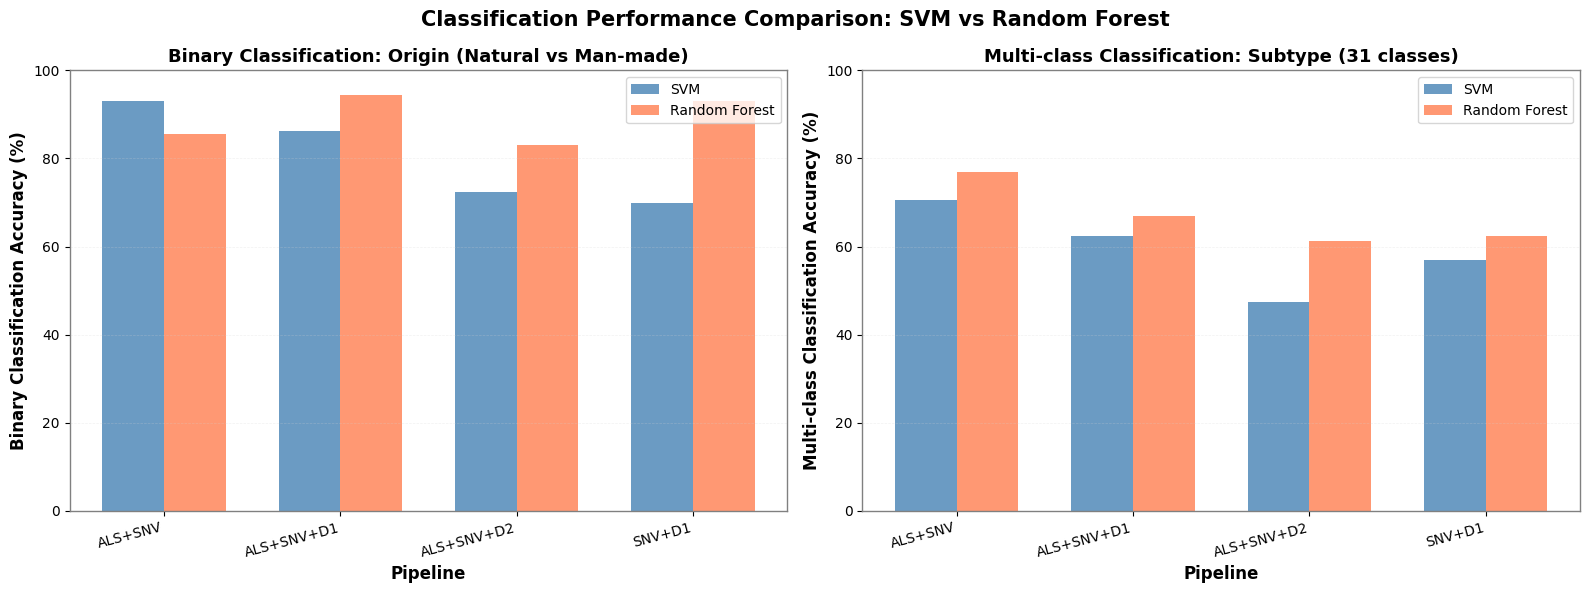

Performance comparison visualization complete


In [147]:
# Visualize performance comparison
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Binary classification comparison
x = np.arange(len(pipeline_names))
width = 0.35

# Sort by original order for visualization
results_sorted = results_df.sort_values('Pipeline')

axes[0].bar(x - width/2, results_sorted['SVM Binary (%)'], width, 
           label='SVM', alpha=0.8, color='steelblue')
axes[0].bar(x + width/2, results_sorted['RF Binary (%)'], width, 
           label='Random Forest', alpha=0.8, color='coral')

axes[0].set_xlabel('Pipeline', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Binary Classification Accuracy (%)', fontsize=12, fontweight='bold')
axes[0].set_title('Binary Classification: Origin (Natural vs Man-made)', 
                 fontsize=13, fontweight='bold')
axes[0].set_xticks(x)
axes[0].set_xticklabels(results_sorted['Pipeline'], rotation=15, ha='right')
axes[0].legend()
axes[0].grid(True, alpha=0.3, axis='y')
axes[0].set_ylim([0, 100])

# Multi-class classification comparison
axes[1].bar(x - width/2, results_sorted['SVM Multi-class (%)'], width, 
           label='SVM', alpha=0.8, color='steelblue')
axes[1].bar(x + width/2, results_sorted['RF Multi-class (%)'], width, 
           label='Random Forest', alpha=0.8, color='coral')

axes[1].set_xlabel('Pipeline', fontsize=12, fontweight='bold')
axes[1].set_ylabel('Multi-class Classification Accuracy (%)', fontsize=12, fontweight='bold')
axes[1].set_title(f'Multi-class Classification: Subtype ({len(np.unique(y_multiclass))} classes)', 
                 fontsize=13, fontweight='bold')
axes[1].set_xticks(x)
axes[1].set_xticklabels(results_sorted['Pipeline'], rotation=15, ha='right')
axes[1].legend()
axes[1].grid(True, alpha=0.3, axis='y')
axes[1].set_ylim([0, 100])

plt.suptitle('Classification Performance Comparison: SVM vs Random Forest', 
             fontsize=15, fontweight='bold')
plt.tight_layout()
plt.show()

print("Performance comparison visualization complete")

### 6.1 Train-Test Split and Detailed Metrics (All Subtypes)

In [148]:
# Check class distribution for stratification
print("Class Distribution Analysis")
print("="*80)

# Check subtype distribution
subtype_counts = pd.Series(y_multiclass).value_counts()
print("\nSubtype sample counts:")
print(subtype_counts)

# Identify classes with very few samples
singletons = subtype_counts[subtype_counts == 1]
small_sample = subtype_counts[subtype_counts < 3]

print(f"\nClasses with 1 sample: {len(singletons)}")
print(f"Classes with <3 samples: {len(small_sample)}")

if len(small_sample) > 0:
    print("\nWarning: Some classes have very few samples. Stratification may be challenging.")
    print("Small sample classes:")
    print(small_sample)


Class Distribution Analysis

Subtype sample counts:
Wool                                         23
PET                                          17
Cotton                                       14
Unspecified Regenerated Cellulose Polymer    11
Silk                                         11
PA 6                                         10
PAN/MA                                        7
PA 6,6                                        7
PP                                            7
Linen                                         6
PAN/VA/VC                                     5
Unspecified PAN (Modacrylic) Copolymer        5
Lyocell                                       4
PAN/VDC                                       4
Cellulose Diacetate                           3
Modal                                         3
PAN/MMA/MA                                    3
PAN/AA/MA                                     2
PAN/VC                                        2
PAN/VBr                             

In [149]:
# Train-Test Split for Pipeline 2
# Using stratification where possible, handling classes with single samples
print("\nTrain-Test Split for Pipeline 2 (ALS+SNV+D1)")
print("="*80)

# For classes with only 1 sample, we cannot stratify them
# We'll handle this by attempting stratification and catching exceptions
from sklearn.model_selection import train_test_split

# Try stratified split
try:
    # Binary classification split
    X_train_bin, X_test_bin, y_train_bin, y_test_bin = train_test_split(
        X_pca_p2, y_binary, test_size=0.2, random_state=42, stratify=y_binary
    )
    print("Binary classification: Stratified split successful")
except:
    X_train_bin, X_test_bin, y_train_bin, y_test_bin = train_test_split(
        X_pca_p2, y_binary, test_size=0.2, random_state=42
    )
    print("Binary classification: Non-stratified split used")

# Multi-class classification split
try:
    X_train_mc, X_test_mc, y_train_mc, y_test_mc = train_test_split(
        X_pca_p2, y_multiclass, test_size=0.2, random_state=42, stratify=y_multiclass
    )
    print("Multi-class classification: Stratified split successful")
except:
    X_train_mc, X_test_mc, y_train_mc, y_test_mc = train_test_split(
        X_pca_p2, y_multiclass, test_size=0.2, random_state=42
    )
    print("Multi-class classification: Non-stratified split used (due to singleton classes)")

print(f"\nBinary - Train: {X_train_bin.shape[0]}, Test: {X_test_bin.shape[0]}")
print(f"Multi-class - Train: {X_train_mc.shape[0]}, Test: {X_test_mc.shape[0]}")



Train-Test Split for Pipeline 2 (ALS+SNV+D1)
Binary classification: Stratified split successful
Multi-class classification: Non-stratified split used (due to singleton classes)

Binary - Train: 128, Test: 32
Multi-class - Train: 128, Test: 32


In [150]:
# Train SVM models and evaluate with detailed metrics
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, classification_report

print("\nSVM Training and Evaluation (Pipeline ALS+SNV+D1)")
print("="*80)

# Binary Classification
print("\n--- Binary Classification (Natural vs Man-made) ---")
svm_binary = SVC(**svm_config)
svm_binary.fit(X_train_bin, y_train_bin)    

# Predictions
train_pred_svm_bin = svm_binary.predict(X_train_bin)
test_pred_svm_bin = svm_binary.predict(X_test_bin)

# Accuracy
train_acc_svm_bin = accuracy_score(y_train_bin, train_pred_svm_bin)
test_acc_svm_bin = accuracy_score(y_test_bin, test_pred_svm_bin)

# Detailed metrics
precision_macro_svm_bin, recall_macro_svm_bin, f1_macro_svm_bin, _ = precision_recall_fscore_support(
    y_test_bin, test_pred_svm_bin, average='macro', zero_division=0
)
precision_micro_svm_bin, recall_micro_svm_bin, f1_micro_svm_bin, _ = precision_recall_fscore_support(
    y_test_bin, test_pred_svm_bin, average='micro', zero_division=0
)
precision_weighted_svm_bin, recall_weighted_svm_bin, f1_weighted_svm_bin, _ = precision_recall_fscore_support(
    y_test_bin, test_pred_svm_bin, average='weighted', zero_division=0
)

print(f"Train Accuracy: {train_acc_svm_bin*100:.2f}%")
print(f"Test Accuracy:  {test_acc_svm_bin*100:.2f}%")
print(f"\nTest Set Metrics:")
print(f"  Precision (macro):   {precision_macro_svm_bin:.4f}")
print(f"  Recall (macro):      {recall_macro_svm_bin:.4f}")
print(f"  F1-Score (macro):    {f1_macro_svm_bin:.4f}")
print(f"  Precision (weighted): {precision_weighted_svm_bin:.4f}")
print(f"  Recall (weighted):    {recall_weighted_svm_bin:.4f}")
print(f"  F1-Score (weighted):  {f1_weighted_svm_bin:.4f}")

# Multi-class Classification
print("\n--- Multi-class Classification (All Subtypes) ---")
svm_multi = SVC(**svm_config)
svm_multi.fit(X_train_mc, y_train_mc)

# Predictions
train_pred_svm_mc = svm_multi.predict(X_train_mc)
test_pred_svm_mc = svm_multi.predict(X_test_mc)

# Accuracy
train_acc_svm_mc = accuracy_score(y_train_mc, train_pred_svm_mc)
test_acc_svm_mc = accuracy_score(y_test_mc, test_pred_svm_mc)

# Detailed metrics
precision_macro_svm_mc, recall_macro_svm_mc, f1_macro_svm_mc, _ = precision_recall_fscore_support(
    y_test_mc, test_pred_svm_mc, average='macro', zero_division=0
)
precision_micro_svm_mc, recall_micro_svm_mc, f1_micro_svm_mc, _ = precision_recall_fscore_support(
    y_test_mc, test_pred_svm_mc, average='micro', zero_division=0
)
precision_weighted_svm_mc, recall_weighted_svm_mc, f1_weighted_svm_mc, _ = precision_recall_fscore_support(
    y_test_mc, test_pred_svm_mc, average='weighted', zero_division=0
)

print(f"Train Accuracy: {train_acc_svm_mc*100:.2f}%")
print(f"Test Accuracy:  {test_acc_svm_mc*100:.2f}%")
print(f"\nTest Set Metrics:")
print(f"  Precision (macro):   {precision_macro_svm_mc:.4f}")
print(f"  Recall (macro):      {recall_macro_svm_mc:.4f}")
print(f"  F1-Score (macro):    {f1_macro_svm_mc:.4f}")
print(f"  Precision (weighted): {precision_weighted_svm_mc:.4f}")
print(f"  Recall (weighted):    {recall_weighted_svm_mc:.4f}")
print(f"  F1-Score (weighted):  {f1_weighted_svm_mc:.4f}")



SVM Training and Evaluation (Pipeline ALS+SNV+D1)

--- Binary Classification (Natural vs Man-made) ---
Train Accuracy: 98.44%
Test Accuracy:  100.00%

Test Set Metrics:
  Precision (macro):   1.0000
  Recall (macro):      1.0000
  F1-Score (macro):    1.0000
  Precision (weighted): 1.0000
  Recall (weighted):    1.0000
  F1-Score (weighted):  1.0000

--- Multi-class Classification (All Subtypes) ---
Train Accuracy: 86.72%
Test Accuracy:  71.88%

Test Set Metrics:
  Precision (macro):   0.4333
  Recall (macro):      0.5000
  F1-Score (macro):    0.4490
  Precision (weighted): 0.6521
  Recall (weighted):    0.7188
  F1-Score (weighted):  0.6729


In [151]:
# Summary Table for All Subtypes Classification
print("\n" + "="*80)
print("SUMMARY: Train-Test Evaluation (All Subtypes)")
print("="*80)

summary_all_subtypes = pd.DataFrame({
    'Classification': ['Binary (Natural vs Man-made)', 'Multi-class (All Subtypes)'],
    'Train Accuracy (%)': [train_acc_svm_bin*100, train_acc_svm_mc*100],
    'Test Accuracy (%)': [test_acc_svm_bin*100, test_acc_svm_mc*100],
    'F1-Macro': [f1_macro_svm_bin, f1_macro_svm_mc],
    'F1-Weighted': [f1_weighted_svm_bin, f1_weighted_svm_mc],
    'Precision-Macro': [precision_macro_svm_bin, precision_macro_svm_mc],
    'Recall-Macro': [recall_macro_svm_bin, recall_macro_svm_mc]
})

print(summary_all_subtypes.to_string(index=False, float_format='%.2f'))
print("\nNote: Macro averages treat all classes equally. Weighted averages account for class imbalance.")



SUMMARY: Train-Test Evaluation (All Subtypes)
              Classification  Train Accuracy (%)  Test Accuracy (%)  F1-Macro  F1-Weighted  Precision-Macro  Recall-Macro
Binary (Natural vs Man-made)               98.44             100.00      1.00         1.00             1.00          1.00
  Multi-class (All Subtypes)               86.72              71.88      0.45         0.67             0.43          0.50

Note: Macro averages treat all classes equally. Weighted averages account for class imbalance.


## 7. Binary Classification Decision Boundary Visualizations

Visualize PCA scatter plots and SVM decision boundaries for **binary classification only** (Natural vs Man-made).

Each pipeline shows:
- **Left**: PCA scatter plot with PC1-PC2
- **Right**: SVM decision boundary overlay on the same PCA space

Creating Binary Classification Decision Boundary Visualizations...

Binary Classification: Natural vs Man-made
--------------------------------------------------------------------------------
  ALS+SNV: 2D SVM Accuracy = 95.62%
  ALS+SNV+D1: 2D SVM Accuracy = 73.75%
  SNV+D1: 2D SVM Accuracy = 76.88%
  ALS+SNV+D2: 2D SVM Accuracy = 66.25%


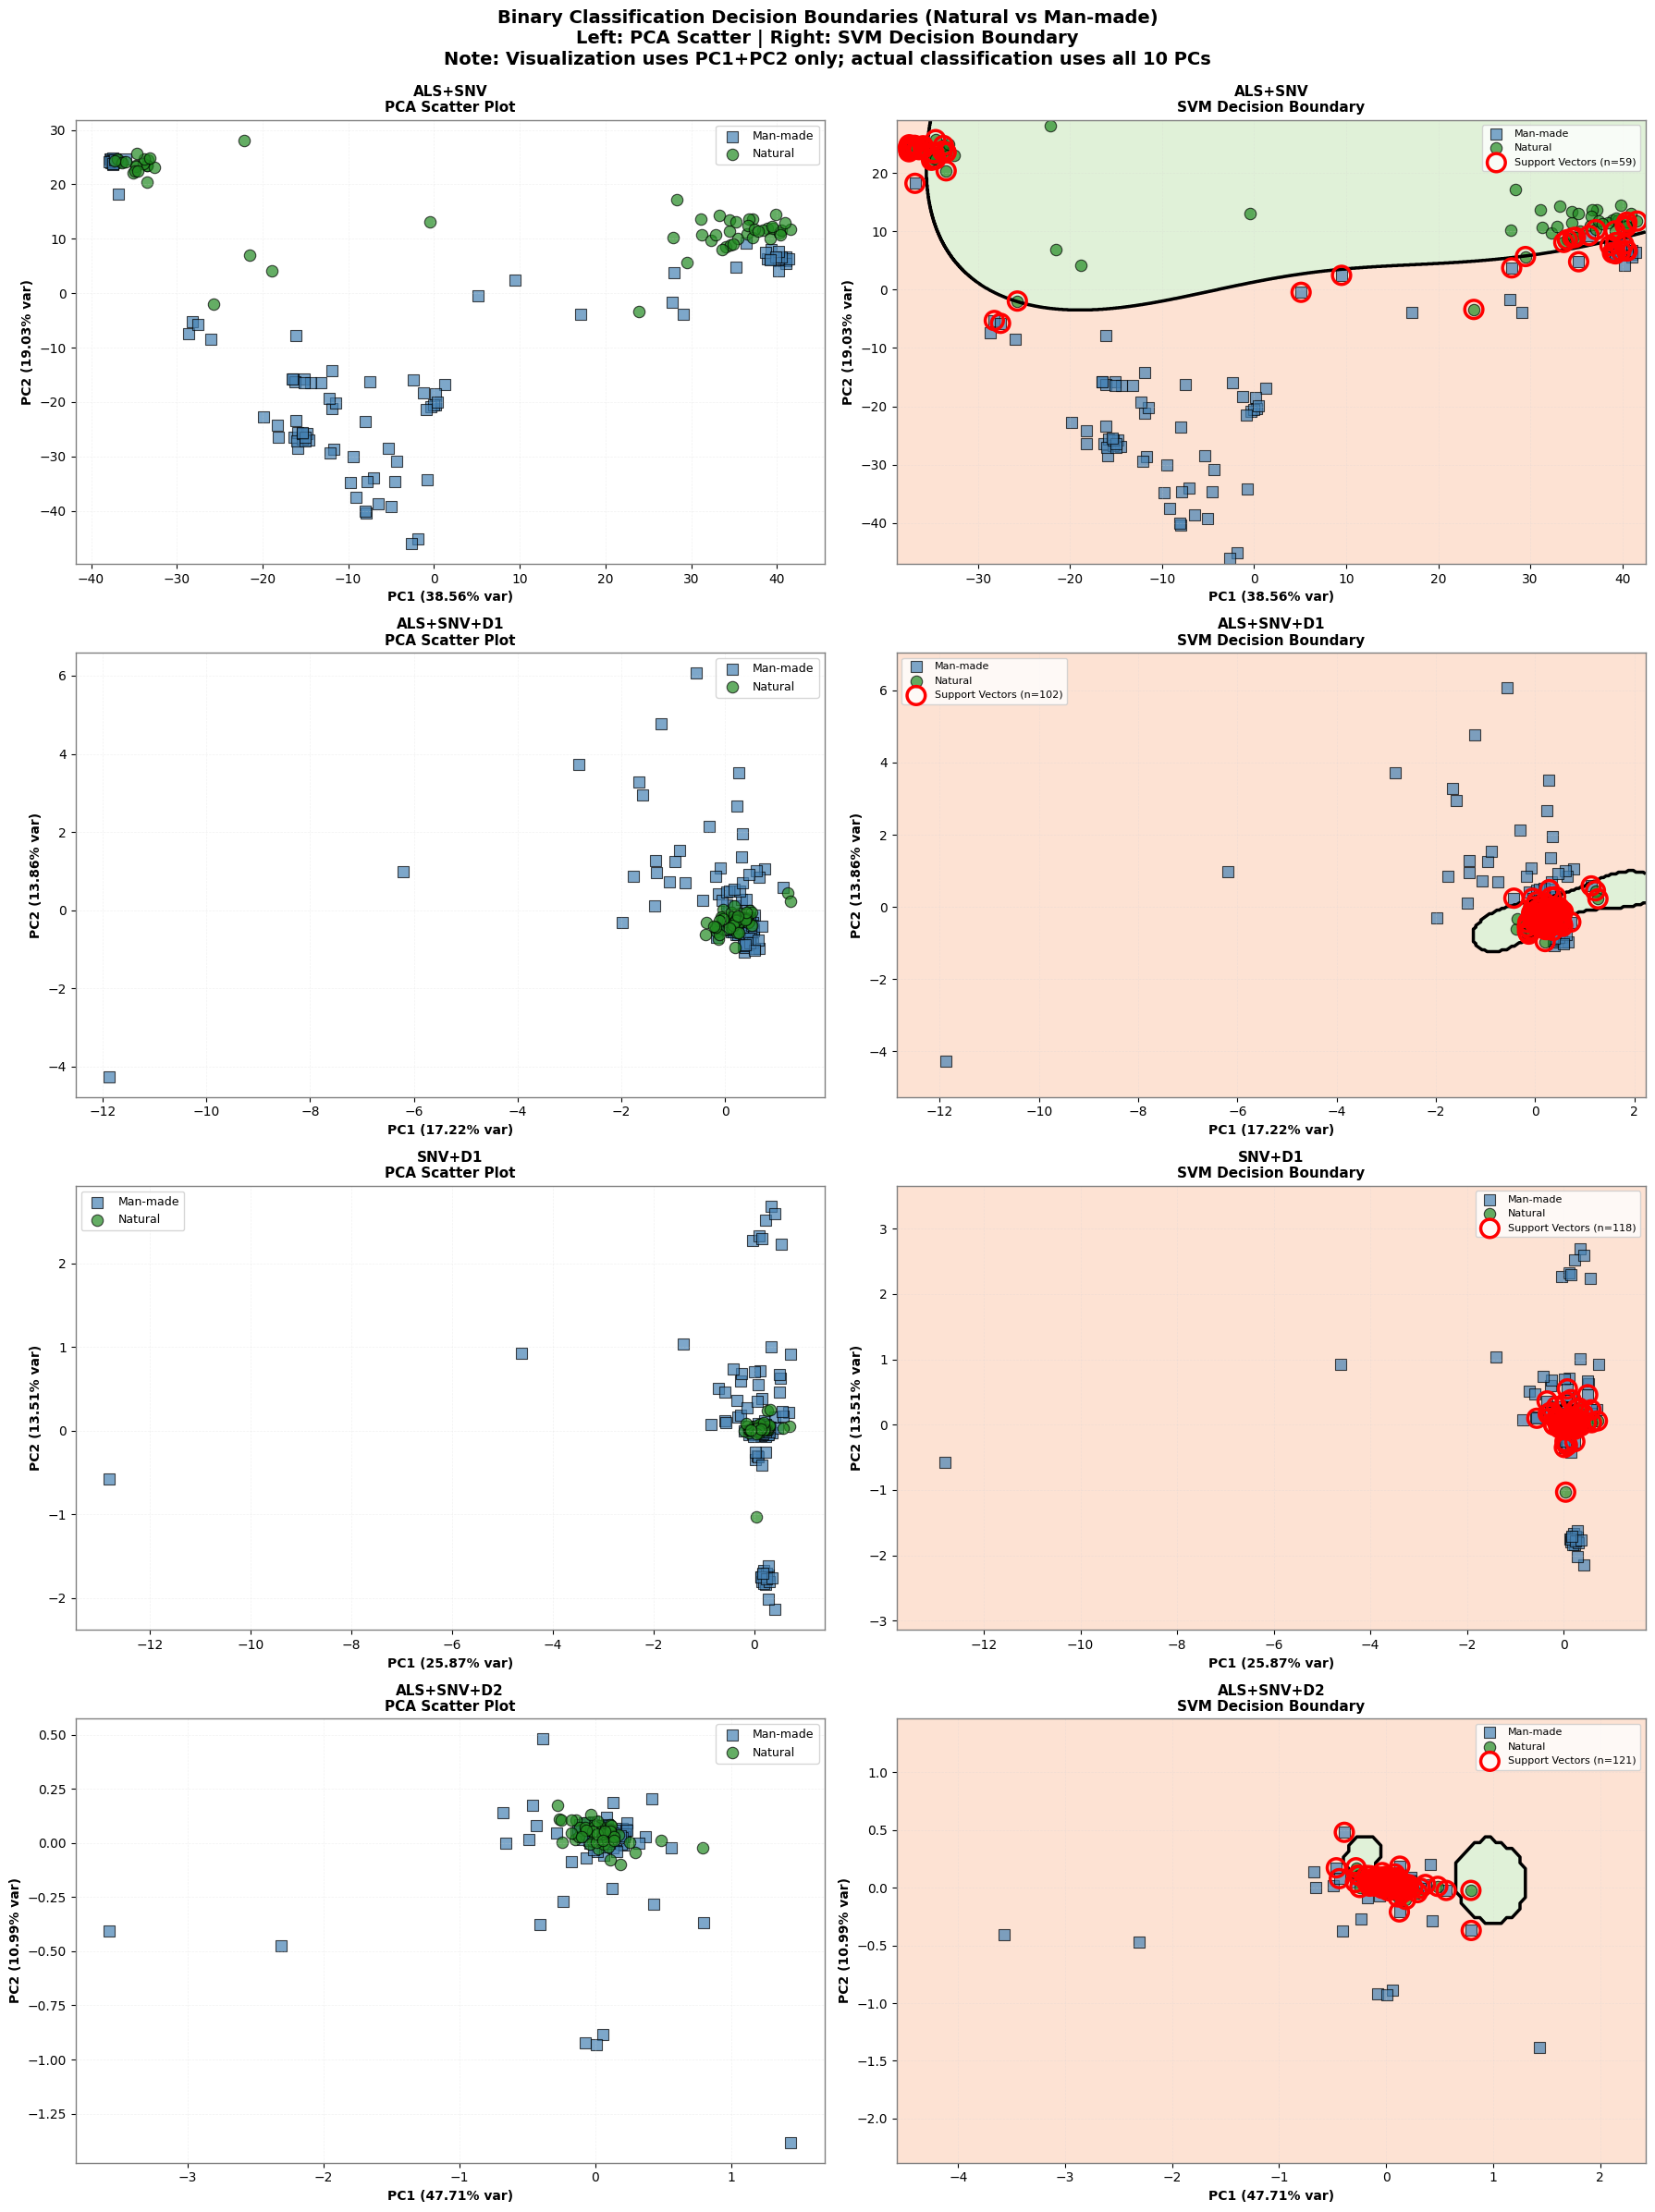


Decision boundary visualization complete!
NOTE: These visualizations use only first 2 PCs (for 2D plotting).
      Actual classification uses all 10 principal components for higher accuracy.


In [152]:
# Binary Classification Decision Boundary Visualization
# Style matching ml_classification.ipynb: Side-by-side PCA + Decision Boundary

print("Creating Binary Classification Decision Boundary Visualizations...")
print("="*80)

def plot_pca_and_decision_boundary(X_pca, y_binary, pipeline_name, pca_obj, row_idx):
    """
    Create side-by-side visualization: PCA scatter plot + Decision boundary.
    
    Parameters:
    -----------
    X_pca : array
        PCA-transformed data (all components)
    y_binary : array
        Binary class labels (Natural vs Man-made)
    pipeline_name : str
        Name of the pipeline
    pca_obj : PCA object
        Fitted PCA object for variance ratios
    row_idx : int
        Row index for subplot placement (0-3 for 4 pipelines)
    """
    # Use only first 2 PCs for visualization
    X_2d = X_pca[:, :2]
    
    # Train SVM on 2D data for visualization
    svm_2d = SVC(kernel='rbf', C=10, gamma='scale', random_state=42)
    svm_2d.fit(X_2d, y_binary)
    
    # Colors for each class
    colors = {'Natural': 'forestgreen', 'Man-made': 'steelblue'}
    markers = {'Natural': 'o', 'Man-made': 's'}
    
    # Left plot: PCA Scatter Plot
    ax1 = plt.subplot(4, 2, row_idx * 2 + 1)
    
    for label in np.unique(y_binary):
        mask = y_binary == label
        ax1.scatter(X_2d[mask, 0], X_2d[mask, 1],
                   c=colors[label], marker=markers[label], 
                   s=80, alpha=0.7, edgecolors='k', linewidth=0.8, label=label)
    
    ax1.set_xlabel(f'PC1 ({pca_obj.explained_variance_ratio_[0]*100:.2f}% var)', 
                   fontsize=10, fontweight='bold')
    ax1.set_ylabel(f'PC2 ({pca_obj.explained_variance_ratio_[1]*100:.2f}% var)', 
                   fontsize=10, fontweight='bold')
    ax1.set_title(f'{pipeline_name}\nPCA Scatter Plot', fontsize=11, fontweight='bold')
    ax1.legend(fontsize=9, loc='best')
    ax1.grid(True, alpha=0.3)
    
    # Right plot: Decision Boundary
    ax2 = plt.subplot(4, 2, row_idx * 2 + 2)
    
    # Create mesh grid for decision boundary
    h = 0.05
    x_min, x_max = X_2d[:, 0].min() - 1, X_2d[:, 0].max() + 1
    y_min, y_max = X_2d[:, 1].min() - 1, X_2d[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    
    # Predict on mesh
    Z = svm_2d.predict(np.c_[xx.ravel(), yy.ravel()])
    
    # Convert labels to numeric for contourf
    label_to_num = {label: idx for idx, label in enumerate(np.unique(y_binary))}
    Z_numeric = np.array([label_to_num[label] for label in Z])
    Z_numeric = Z_numeric.reshape(xx.shape)
    
    # Plot decision regions
    ax2.contourf(xx, yy, Z_numeric, alpha=0.25, cmap='RdYlGn', levels=1)
    
    # Plot decision boundary
    ax2.contour(xx, yy, Z_numeric, colors='black', linewidths=2.5, 
                linestyles='solid', levels=[0.5])
    
    # Plot data points
    for label in np.unique(y_binary):
        mask = y_binary == label
        ax2.scatter(X_2d[mask, 0], X_2d[mask, 1],
                   c=colors[label], marker=markers[label], 
                   s=80, alpha=0.7, edgecolors='k', linewidth=0.8, label=label)
    
    # Highlight support vectors
    support_vectors = svm_2d.support_vectors_
    ax2.scatter(support_vectors[:, 0], support_vectors[:, 1],
               s=200, linewidth=2.5, facecolors='none', edgecolors='red',
               label=f'Support Vectors (n={len(support_vectors)})', zorder=5)
    
    ax2.set_xlabel(f'PC1 ({pca_obj.explained_variance_ratio_[0]*100:.2f}% var)', 
                   fontsize=10, fontweight='bold')
    ax2.set_ylabel(f'PC2 ({pca_obj.explained_variance_ratio_[1]*100:.2f}% var)', 
                   fontsize=10, fontweight='bold')
    ax2.set_title(f'{pipeline_name}\nSVM Decision Boundary', fontsize=11, fontweight='bold')
    ax2.legend(fontsize=8, loc='best', ncol=1)
    ax2.grid(True, alpha=0.3)
    
    # Get accuracy
    accuracy = svm_2d.score(X_2d, y_binary)
    return accuracy


# Create figure with 4 rows (one per pipeline) x 2 columns (PCA + Decision Boundary)
fig = plt.figure(figsize=(18, 24))

print("\nBinary Classification: Natural vs Man-made")
print("-"*80)

pca_objects = [pca_p1, pca_p2, pca_p3, pca_p4]
accuracies = []

for idx, (X_pca, pca_obj, name) in enumerate(zip(X_pca_list, pca_objects, pipeline_names)):
    accuracy = plot_pca_and_decision_boundary(X_pca, y_binary, name, pca_obj, idx)
    accuracies.append(accuracy)
    print(f"  {name}: 2D SVM Accuracy = {accuracy*100:.2f}%")

plt.suptitle('Binary Classification Decision Boundaries (Natural vs Man-made)\n' +
             'Left: PCA Scatter | Right: SVM Decision Boundary\n' +
             'Note: Visualization uses PC1+PC2 only; actual classification uses all 10 PCs',
             fontsize=14, fontweight='bold', y=0.995)
plt.tight_layout()
plt.show()

print("\n" + "="*80)
print("Decision boundary visualization complete!")
print("NOTE: These visualizations use only first 2 PCs (for 2D plotting).")
print("      Actual classification uses all 10 principal components for higher accuracy.")
print("="*80)

## 8. Preprocessing Stages Visualization: Natural vs Man-made

Creating preprocessing stages visualization...

Selected samples:
  Natural: Alpaca (Sample MTA_ALP_073)
  Man-made: Cellulose Diacetate (Sample MTF_ACT_001)


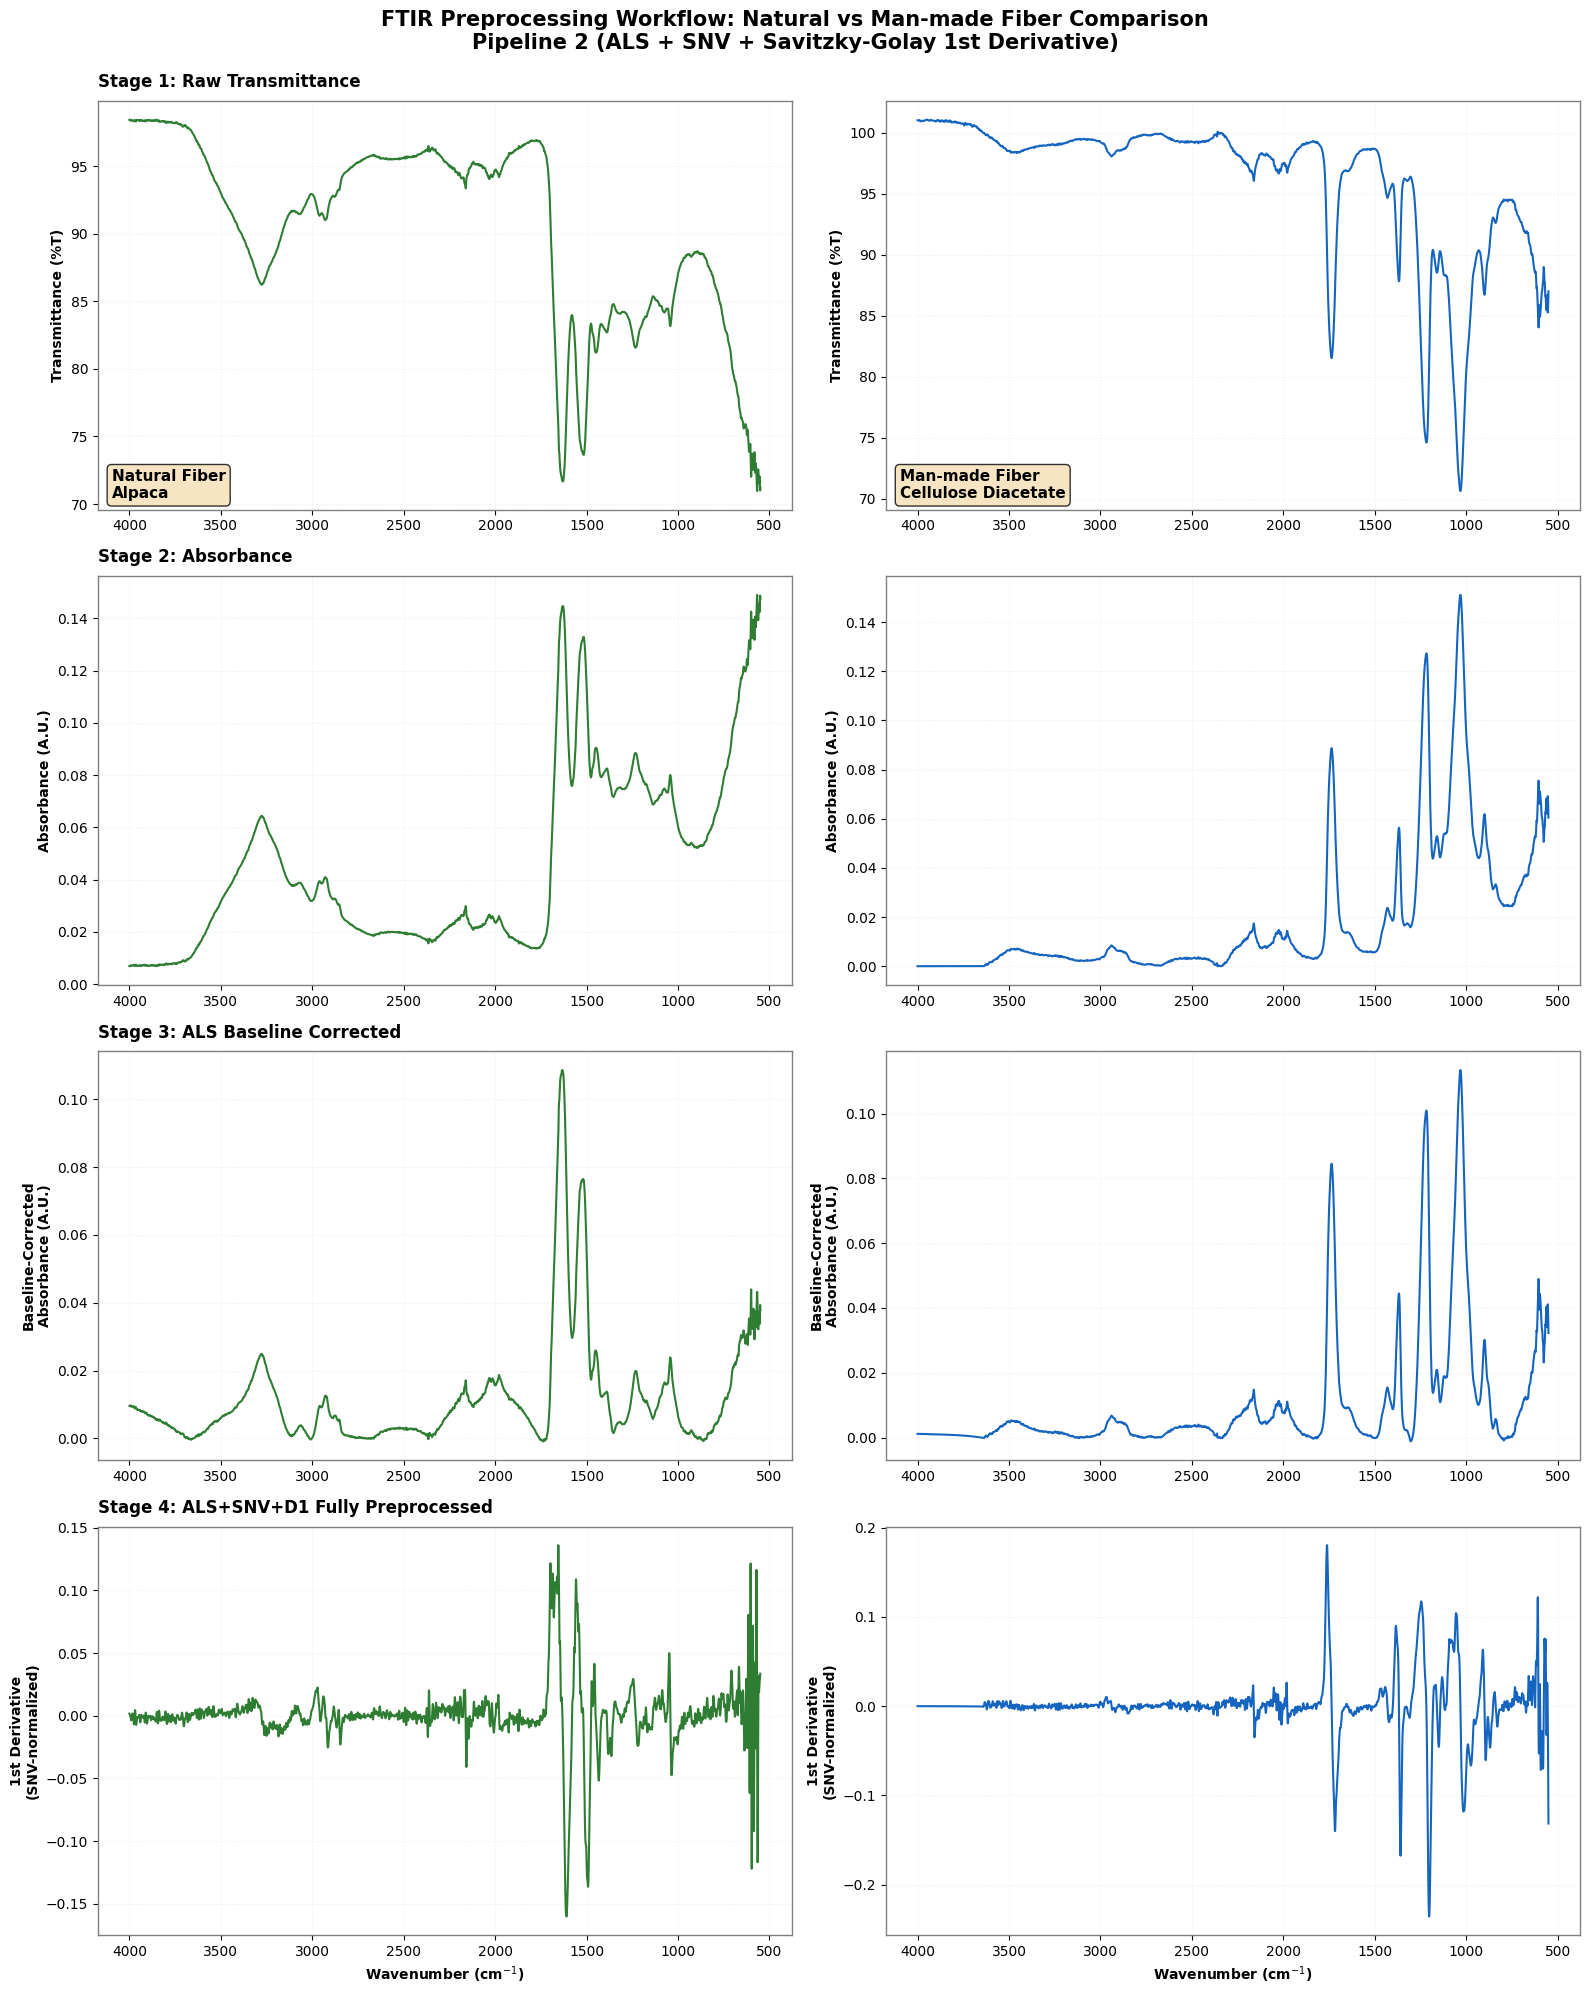


✓ Full preprocessing visualization saved to: images\preprocessing_pipeline_A.png


In [153]:
# Visualize preprocessing stages for Natural and Man-made fiber examples
print("Creating preprocessing stages visualization...")
print("="*80)

# Select representative samples: one Natural, one Man-made
natural_idx = np.where(origins == 'Natural')[0][0]
manmade_idx = np.where(origins == 'Man-made')[0][0]

print(f"\nSelected samples:")
print(f"  Natural: {subtypes[natural_idx]} (Sample {sample_ids[natural_idx]})")
print(f"  Man-made: {subtypes[manmade_idx]} (Sample {sample_ids[manmade_idx]})")

# Create figure: 4 rows (stages) x 2 columns (Natural, Man-made)
fig, axes = plt.subplots(4, 2, figsize=(16, 20))

# Column labels (for Natural and Man-made)
col_labels = [
    f"Natural Fiber\n{subtypes[natural_idx]}",
    f"Man-made Fiber\n{subtypes[manmade_idx]}"
]

# Row titles (for stages)
row_titles = [
    'Stage 1: Raw Transmittance',
    'Stage 2: Absorbance',
    'Stage 3: ALS Baseline Corrected',
    'Stage 4: ALS+SNV+D1 Fully Preprocessed'
]

# Define colors for each fiber type
fiber_colors = {'Natural': '#2e7d32', 'Man-made': '#1565c0'}  # Green for Natural, Blue for Man-made
stage_colors = [fiber_colors[origins[natural_idx]], fiber_colors[origins[manmade_idx]]]

# Process both samples (now as columns)
for col_idx, sample_idx in enumerate([natural_idx, manmade_idx]):
    
    # Stage 1: Raw Transmittance
    axes[0, col_idx].plot(wavenumbers, transmittance_spectra[sample_idx], 
                         color=stage_colors[col_idx], linewidth=1.5)
    axes[0, col_idx].set_ylabel('Transmittance (%T)', fontsize=10, fontweight='bold')
    axes[0, col_idx].invert_xaxis()
    axes[0, col_idx].grid(True, alpha=0.3)
    
    # Add label on bottom-left of first stage plot
    axes[0, col_idx].text(0.02, 0.02, col_labels[col_idx],
                         transform=axes[0, col_idx].transAxes,
                         fontsize=11, fontweight='bold',
                         verticalalignment='bottom',
                         bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))
    
    # Stage 2: Absorbance
    axes[1, col_idx].plot(wavenumbers, absorbance_spectra[sample_idx],
                         color=stage_colors[col_idx], linewidth=1.5)
    axes[1, col_idx].set_ylabel('Absorbance (A.U.)', fontsize=10, fontweight='bold')
    axes[1, col_idx].invert_xaxis()
    axes[1, col_idx].grid(True, alpha=0.3)
    
    # Stage 3: ALS Baseline Corrected
    axes[2, col_idx].plot(wavenumbers, als_corrected_absorbance[sample_idx],
                         color=stage_colors[col_idx], linewidth=1.5)
    axes[2, col_idx].set_ylabel('Baseline-Corrected\nAbsorbance (A.U.)', fontsize=10, fontweight='bold')
    axes[2, col_idx].invert_xaxis()
    axes[2, col_idx].grid(True, alpha=0.3)
    
    # Stage 4: P2 Pipeline (ALS+SNV+D1)
    axes[3, col_idx].plot(wavenumbers, pipeline_2_data[sample_idx],
                         color=stage_colors[col_idx], linewidth=1.5)
    axes[3, col_idx].set_ylabel('1st Derivative\n(SNV-normalized)', fontsize=10, fontweight='bold')
    axes[3, col_idx].invert_xaxis()
    axes[3, col_idx].grid(True, alpha=0.3)
    
    # Set x-label only for bottom row
    axes[3, col_idx].set_xlabel(r'Wavenumber (cm$^{-1}$)', 
                                fontsize=10, fontweight='bold')

# Set row titles on the left
for row_idx, title in enumerate(row_titles):
    axes[row_idx, 0].set_title(title, fontsize=12, fontweight='bold', pad=10, loc='left')

plt.suptitle('FTIR Preprocessing Workflow: Natural vs Man-made Fiber Comparison\n' +
             'Pipeline 2 (ALS + SNV + Savitzky-Golay 1st Derivative)',
             fontsize=15, fontweight='bold', y=0.995)
plt.tight_layout()

# Save the figure
output_dir = Path('images')
output_dir.mkdir(exist_ok=True)
output_path = output_dir / 'preprocessing_pipeline_A.png'
plt.savefig(output_path, dpi=300, bbox_inches='tight', facecolor='white')

plt.show()

print(f"\n✓ Full preprocessing visualization saved to: {output_path}")



Loaded baseline-corrected transmittance: (160, 3451)

✓ Simplified preprocessing visualization saved to: images\preprocessing_pipeline_T.png


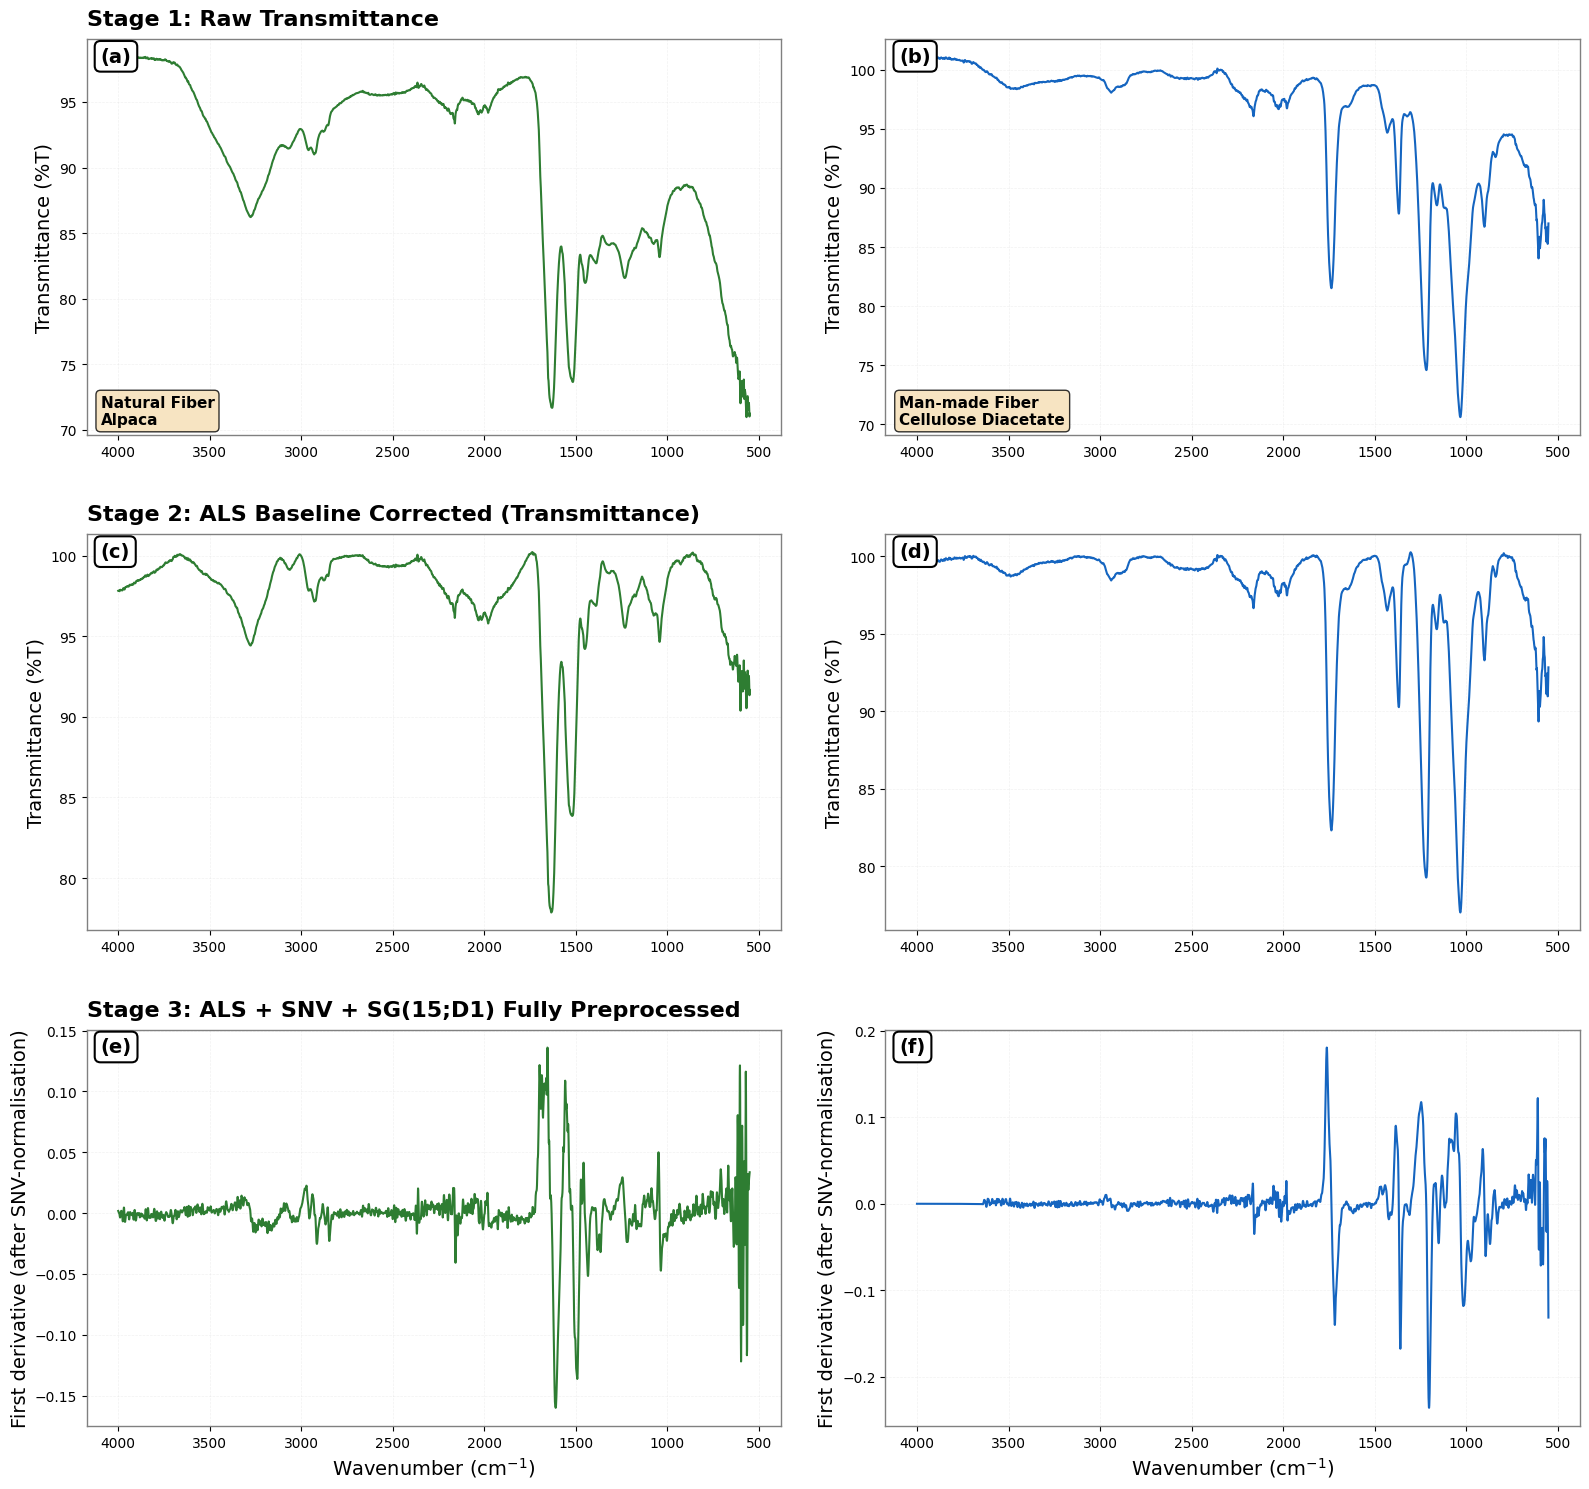

In [154]:
# Simplified preprocessing visualization: Raw Transmittance -> ALS Baseline (in %T) -> Fully Preprocessed
# Load ALS baseline corrected transmittance data
df_baseline_corrected = pd.read_csv(data_dir / 'feature_matrix_baseline_corrected_T.csv')

# Extract baseline corrected transmittance spectra
baseline_corrected_T = df_baseline_corrected[spectral_cols].values

print(f"\nLoaded baseline-corrected transmittance: {baseline_corrected_T.shape}")

# Create figure: 3 rows (stages) x 2 columns (Natural, Man-made)
fig, axes = plt.subplots(3, 2, figsize=(16, 15))

# Row titles (for 3 stages)
row_titles_simple = [
    'Stage 1: Raw Transmittance',
    'Stage 2: ALS Baseline Corrected (Transmittance)',
    'Stage 3: ALS + SNV + SG(15;D1) Fully Preprocessed'
]

# Define colors for each fiber type
fiber_colors = {'Natural': '#2e7d32', 'Man-made': '#1565c0'}  # Green for Natural, Blue for Man-made
stage_colors = [fiber_colors[origins[natural_idx]], fiber_colors[origins[manmade_idx]]]

# Process both samples
subplot_letters = ['a', 'b', 'c', 'd', 'e', 'f']

# Process both samples
for col_idx, sample_idx in enumerate([natural_idx, manmade_idx]):
    
    # Stage 1: Raw Transmittance
    axes[0, col_idx].plot(wavenumbers, transmittance_spectra[sample_idx], 
                         color=stage_colors[col_idx], linewidth=1.5)
    axes[0, col_idx].set_ylabel('Transmittance (%T)', fontsize=14)
    axes[0, col_idx].invert_xaxis()
    axes[0, col_idx].grid(True, alpha=0.3)
    
    # Add letter index (a) or (b) to top-left corner
    letter_idx = col_idx  # 0='a', 1='b'
    axes[0, col_idx].text(0.02, 0.98, f'({subplot_letters[letter_idx]})',
                         transform=axes[0, col_idx].transAxes,
                         fontsize=14, fontweight='bold',
                         verticalalignment='top', horizontalalignment='left',
                         bbox=dict(boxstyle='round', facecolor='white', edgecolor='black', linewidth=1.5))
    
    # Add label on bottom-left of first stage plot
    axes[0, col_idx].text(0.02, 0.02, col_labels[col_idx],
                         transform=axes[0, col_idx].transAxes,
                         fontsize=11, fontweight='bold',
                         verticalalignment='bottom',
                         bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))
    
    # Stage 2: ALS Baseline Corrected (in Transmittance)
    axes[1, col_idx].plot(wavenumbers, baseline_corrected_T[sample_idx],
                         color=stage_colors[col_idx], linewidth=1.5)
    axes[1, col_idx].set_ylabel('Transmittance (%T)', fontsize=14)
    axes[1, col_idx].invert_xaxis()
    axes[1, col_idx].grid(True, alpha=0.3)
    
    # Add letter index (c) or (d) to top-left corner
    letter_idx = 2 + col_idx  # 2='c', 3='d'
    axes[1, col_idx].text(0.02, 0.98, f'({subplot_letters[letter_idx]})',
                         transform=axes[1, col_idx].transAxes,
                         fontsize=14, fontweight='bold',
                         verticalalignment='top', horizontalalignment='left',
                         bbox=dict(boxstyle='round', facecolor='white', edgecolor='black', linewidth=1.5))
    
    # Stage 3: P2 Pipeline (ALS+SNV+D1)
    axes[2, col_idx].plot(wavenumbers, pipeline_2_data[sample_idx],
                         color=stage_colors[col_idx], linewidth=1.5)
    axes[2, col_idx].set_ylabel('First derivative (after SNV-normalisation)', fontsize=14)
    axes[2, col_idx].invert_xaxis()
    axes[2, col_idx].grid(True, alpha=0.3)
    
    # Add letter index (e) or (f) to top-left corner
    letter_idx = 4 + col_idx  # 4='e', 5='f'
    axes[2, col_idx].text(0.02, 0.98, f'({subplot_letters[letter_idx]})',
                         transform=axes[2, col_idx].transAxes,
                         fontsize=14, fontweight='bold',
                         verticalalignment='top', horizontalalignment='left',
                         bbox=dict(boxstyle='round', facecolor='white', edgecolor='black', linewidth=1.5))
    
    # Set x-label only for bottom row
    axes[2, col_idx].set_xlabel(r'Wavenumber (cm$^{-1}$)', fontsize=14)

# Set row titles on the left
for row_idx, title in enumerate(row_titles_simple):
    axes[row_idx, 0].set_title(title, fontsize=16, fontweight='bold', pad=10, loc='left')


plt.tight_layout()
plt.subplots_adjust(wspace=0.15)  # Increase horizontal spacing between columns (Natural vs Synthetic)
plt.subplots_adjust(hspace=0.25) 

# Save the figure
output_path_simple = output_dir / 'preprocessing_pipeline_T.png'
plt.savefig(output_path_simple, dpi=300, bbox_inches='tight', facecolor='white')
print(f"\n✓ Simplified preprocessing visualization saved to: {output_path_simple}")
plt.show()


## 9. Classification Analysis: Excluding Unspecified Subtypes

Perform classification analysis excluding samples with "Unspecified" in their Subtype labels to focus on well-defined fiber categories.

In [155]:
# Filter out samples with "Unspecified" in Subtype
print("Filtering out Unspecified Subtypes...")
print("="*80)

# Create mask for specified subtypes only
mask_specified = ~np.array([('Unspecified' in str(subtype)) for subtype in subtypes])

print(f"Total samples: {len(subtypes)}")
print(f"Specified subtypes: {np.sum(mask_specified)}")
print(f"Unspecified subtypes: {np.sum(~mask_specified)}")

# Filter data
y_binary_specified = origins[mask_specified]
y_multiclass_specified = subtypes[mask_specified]

# Filter PCA data for all pipelines
X_pca_p1_specified = X_pca_p1[mask_specified]
X_pca_p2_specified = X_pca_p2[mask_specified]
X_pca_p3_specified = X_pca_p3[mask_specified]
X_pca_p4_specified = X_pca_p4[mask_specified]

X_pca_list_specified = [X_pca_p1_specified, X_pca_p2_specified, X_pca_p3_specified, X_pca_p4_specified]

print(f"\nFiltered dataset shape: {X_pca_p1_specified.shape}")
print(f"Number of specified subtypes: {len(np.unique(y_multiclass_specified))}")
print(f"Specified subtypes: {sorted(np.unique(y_multiclass_specified))}")


Filtering out Unspecified Subtypes...
Total samples: 160
Specified subtypes: 141
Unspecified subtypes: 19

Filtered dataset shape: (141, 10)
Number of specified subtypes: 26
Specified subtypes: ['Alpaca', 'Cellulose Diacetate', 'Cellulose Triacetate', 'Cotton', 'Jute', 'Linen', 'Lyocell', 'Meta-Aramid', 'Modal', 'PA 6', 'PA 6,6', 'PAN/AA/MA', 'PAN/MA', 'PAN/MMA/MA', 'PAN/VA', 'PAN/VA/VC', 'PAN/VBr', 'PAN/VC', 'PAN/VDC', 'PE', 'PET', 'PP', 'Para-Aramid', 'Silk', 'Viscose', 'Wool']


In [156]:
# Train SVM classifiers on specified subtypes only
print("Training SVM classifiers on specified subtypes (RBF kernel, C=10)...")
print("="*80)

# Store results for specified subtypes
svm_results_specified = {
    'pipeline': [],
    'binary_cv_mean': [],
    'binary_cv_std': [],
    'multiclass_cv_mean': [],
    'multiclass_cv_std': []
}

for idx, (X_pca, name) in enumerate(zip(X_pca_list_specified, pipeline_names)):
    print(f"\n{name}:")
    print("-" * 80)
    
    # Binary classification
    svm_binary = SVC(**svm_config)
    cv_scores_binary = cross_val_score(
        svm_binary, X_pca, y_binary_specified, 
        cv=5, scoring='accuracy', n_jobs=-1
    )
    
    print(f"  Binary (Origin):")
    print(f"    CV Accuracy: {cv_scores_binary.mean()*100:.2f}% (+/- {cv_scores_binary.std()*100:.2f}%)")
    
    # Multi-class classification
    svm_multiclass = SVC(**svm_config)
    cv_scores_multiclass = cross_val_score(
        svm_multiclass, X_pca, y_multiclass_specified, 
        cv=5, scoring='accuracy', n_jobs=-1
    )
    
    print(f"  Multi-class (Subtype):")
    print(f"    CV Accuracy: {cv_scores_multiclass.mean()*100:.2f}% (+/- {cv_scores_multiclass.std()*100:.2f}%)")
    
    # Store results
    svm_results_specified['pipeline'].append(name)
    svm_results_specified['binary_cv_mean'].append(cv_scores_binary.mean() * 100)
    svm_results_specified['binary_cv_std'].append(cv_scores_binary.std() * 100)
    svm_results_specified['multiclass_cv_mean'].append(cv_scores_multiclass.mean() * 100)
    svm_results_specified['multiclass_cv_std'].append(cv_scores_multiclass.std() * 100)

print("\n" + "="*80)
print("SVM classification complete on specified subtypes!")


Training SVM classifiers on specified subtypes (RBF kernel, C=10)...

ALS+SNV:
--------------------------------------------------------------------------------
  Binary (Origin):
    CV Accuracy: 95.02% (+/- 3.65%)
  Multi-class (Subtype):
    CV Accuracy: 72.36% (+/- 6.80%)

ALS+SNV+D1:
--------------------------------------------------------------------------------
  Binary (Origin):
    CV Accuracy: 88.65% (+/- 10.70%)
  Multi-class (Subtype):
    CV Accuracy: 69.46% (+/- 4.52%)

SNV+D1:
--------------------------------------------------------------------------------
  Binary (Origin):
    CV Accuracy: 90.05% (+/- 11.40%)
  Multi-class (Subtype):
    CV Accuracy: 63.03% (+/- 6.94%)

ALS+SNV+D2:
--------------------------------------------------------------------------------
  Binary (Origin):
    CV Accuracy: 81.55% (+/- 14.37%)
  Multi-class (Subtype):
    CV Accuracy: 56.70% (+/- 5.94%)

SVM classification complete on specified subtypes!


In [157]:
# Train Random Forest classifiers on specified subtypes only
print("Training Random Forest classifiers on specified subtypes (200 trees)...")
print("="*80)

# Store results for specified subtypes
rf_results_specified = {
    'pipeline': [],
    'binary_cv_mean': [],
    'binary_cv_std': [],
    'multiclass_cv_mean': [],
    'multiclass_cv_std': []
}

for idx, (X_pca, name) in enumerate(zip(X_pca_list_specified, pipeline_names)):
    print(f"\n{name}:")
    print("-" * 80)
    
    # Binary classification
    rf_binary = RandomForestClassifier(**rf_config)
    cv_scores_binary = cross_val_score(
        rf_binary, X_pca, y_binary_specified, 
        cv=5, scoring='accuracy', n_jobs=-1
    )
    
    print(f"  Binary (Origin):")
    print(f"    CV Accuracy: {cv_scores_binary.mean()*100:.2f}% (+/- {cv_scores_binary.std()*100:.2f}%)")
    
    # Multi-class classification
    rf_multiclass = RandomForestClassifier(**rf_config)
    cv_scores_multiclass = cross_val_score(
        rf_multiclass, X_pca, y_multiclass_specified, 
        cv=5, scoring='accuracy', n_jobs=-1
    )
    
    print(f"  Multi-class (Subtype):")
    print(f"    CV Accuracy: {cv_scores_multiclass.mean()*100:.2f}% (+/- {cv_scores_multiclass.std()*100:.2f}%)")
    
    # Store results
    rf_results_specified['pipeline'].append(name)
    rf_results_specified['binary_cv_mean'].append(cv_scores_binary.mean() * 100)
    rf_results_specified['binary_cv_std'].append(cv_scores_binary.std() * 100)
    rf_results_specified['multiclass_cv_mean'].append(cv_scores_multiclass.mean() * 100)
    rf_results_specified['multiclass_cv_std'].append(cv_scores_multiclass.std() * 100)

print("\n" + "="*80)
print("Random Forest classification complete on specified subtypes!")


Training Random Forest classifiers on specified subtypes (200 trees)...

ALS+SNV:
--------------------------------------------------------------------------------
  Binary (Origin):
    CV Accuracy: 89.31% (+/- 9.86%)
  Multi-class (Subtype):
    CV Accuracy: 81.53% (+/- 4.27%)

ALS+SNV+D1:
--------------------------------------------------------------------------------
  Binary (Origin):
    CV Accuracy: 93.62% (+/- 9.69%)
  Multi-class (Subtype):
    CV Accuracy: 72.98% (+/- 5.56%)

SNV+D1:
--------------------------------------------------------------------------------
  Binary (Origin):
    CV Accuracy: 90.74% (+/- 10.27%)
  Multi-class (Subtype):
    CV Accuracy: 70.15% (+/- 8.18%)

ALS+SNV+D2:
--------------------------------------------------------------------------------
  Binary (Origin):
    CV Accuracy: 81.55% (+/- 7.64%)
  Multi-class (Subtype):
    CV Accuracy: 63.08% (+/- 7.85%)

Random Forest classification complete on specified subtypes!


In [158]:
# Comparison Table 1: All 4 Pipelines (Specified Subtypes Only)
print("Classification Performance: Specified Subtypes Only")
print("="*80)
print("\nTable 1: All pipelines comparison")
print("-"*80)

results_specified_all = pd.DataFrame({
    'Pipeline': pipeline_names,
    'SVM Binary (%)': svm_results_specified['binary_cv_mean'],
    'SVM Multi-class (%)': svm_results_specified['multiclass_cv_mean'],
    'RF Binary (%)': rf_results_specified['binary_cv_mean'],
    'RF Multi-class (%)': rf_results_specified['multiclass_cv_mean'],
    'PC1+PC2 Var (%)': [
        pca_p1.explained_variance_ratio_[:2].sum() * 100,
        pca_p2.explained_variance_ratio_[:2].sum() * 100,
        pca_p3.explained_variance_ratio_[:2].sum() * 100,
        pca_p4.explained_variance_ratio_[:2].sum() * 100
    ]
})

results_specified_all['Avg Binary (%)'] = results_specified_all[['SVM Binary (%)', 'RF Binary (%)']].mean(axis=1)
results_specified_all['Avg Multi-class (%)'] = results_specified_all[['SVM Multi-class (%)', 'RF Multi-class (%)']].mean(axis=1)
results_specified_all['Overall Avg (%)'] = results_specified_all[['Avg Binary (%)', 'Avg Multi-class (%)']].mean(axis=1)

results_specified_all = results_specified_all.sort_values('Overall Avg (%)', ascending=False)
print(results_specified_all.to_string(index=False, float_format='%.2f'))


Classification Performance: Specified Subtypes Only

Table 1: All pipelines comparison
--------------------------------------------------------------------------------
  Pipeline  SVM Binary (%)  SVM Multi-class (%)  RF Binary (%)  RF Multi-class (%)  PC1+PC2 Var (%)  Avg Binary (%)  Avg Multi-class (%)  Overall Avg (%)
   ALS+SNV           95.02                72.36          89.31               81.53            57.59           92.17                76.95            84.56
ALS+SNV+D1           88.65                69.46          93.62               72.98            31.08           91.13                71.22            81.18
    SNV+D1           90.05                63.03          90.74               70.15            39.38           90.39                66.59            78.49
ALS+SNV+D2           81.55                56.70          81.55               63.08            58.70           81.55                59.89            70.72


In [159]:
# Comparison Table 2: 3 Pipelines without PC1+PC2 Variance (Specified Subtypes Only)
print("\nPipelines Comparison: Specified Subtypes Only for Multi-Class")
print("-"*80)

results_specified_filtered = pd.DataFrame({
    'Pipeline': pipeline_names,
    'SVM Binary (%)': svm_results_specified['binary_cv_mean'],
    'SVM Multi-class (%)': svm_results_specified['multiclass_cv_mean'],
    'RF Binary (%)': rf_results_specified['binary_cv_mean'],
    'RF Multi-class (%)': rf_results_specified['multiclass_cv_mean']
})

results_specified_filtered['Avg Binary (%)'] = results_specified_filtered[['SVM Binary (%)', 'RF Binary (%)']].mean(axis=1)
results_specified_filtered['Avg Multi-class (%)'] = results_specified_filtered[['SVM Multi-class (%)', 'RF Multi-class (%)']].mean(axis=1)
results_specified_filtered['Overall Avg (%)'] = results_specified_filtered[['Avg Binary (%)', 'Avg Multi-class (%)']].mean(axis=1)

results_specified_filtered = results_specified_filtered[results_specified_filtered['Pipeline'] != 'SNV+D1']
print(results_specified_filtered.to_string(index=False, float_format='%.2f'))



Pipelines Comparison: Specified Subtypes Only for Multi-Class
--------------------------------------------------------------------------------
  Pipeline  SVM Binary (%)  SVM Multi-class (%)  RF Binary (%)  RF Multi-class (%)  Avg Binary (%)  Avg Multi-class (%)  Overall Avg (%)
   ALS+SNV           95.02                72.36          89.31               81.53           92.17                76.95            84.56
ALS+SNV+D1           88.65                69.46          93.62               72.98           91.13                71.22            81.18
ALS+SNV+D2           81.55                56.70          81.55               63.08           81.55                59.89            70.72


### 9.1 Train-Test Split and Detailed Metrics (Specified Subtypes Only)

In [160]:
# Train-Test Split for Specified Subtypes (Pipeline 2)
print("\nTrain-Test Split for Specified Subtypes (Pipeline 2)")
print("="*80)

# Check class distribution
subtype_counts_spec = pd.Series(y_multiclass_specified).value_counts()
print("\nSpecified Subtype sample counts:")
print(subtype_counts_spec)

# Try stratified split
try:
    X_train_bin_spec, X_test_bin_spec, y_train_bin_spec, y_test_bin_spec = train_test_split(
        X_pca_p2_specified, y_binary_specified, test_size=0.2, random_state=42, stratify=y_binary_specified
    )
    print("\nBinary classification: Stratified split successful")
except:
    X_train_bin_spec, X_test_bin_spec, y_train_bin_spec, y_test_bin_spec = train_test_split(
        X_pca_p2_specified, y_binary_specified, test_size=0.2, random_state=42
    )
    print("\nBinary classification: Non-stratified split used")

try:
    X_train_mc_spec, X_test_mc_spec, y_train_mc_spec, y_test_mc_spec = train_test_split(
        X_pca_p2_specified, y_multiclass_specified, test_size=0.2, random_state=42, stratify=y_multiclass_specified
    )
    print("Multi-class classification: Stratified split successful")
except:
    X_train_mc_spec, X_test_mc_spec, y_train_mc_spec, y_test_mc_spec = train_test_split(
        X_pca_p2_specified, y_multiclass_specified, test_size=0.2, random_state=42
    )
    print("Multi-class classification: Non-stratified split used")

print(f"\nBinary - Train: {X_train_bin_spec.shape[0]}, Test: {X_test_bin_spec.shape[0]}")
print(f"Multi-class - Train: {X_train_mc_spec.shape[0]}, Test: {X_test_mc_spec.shape[0]}")



Train-Test Split for Specified Subtypes (Pipeline 2)

Specified Subtype sample counts:
Wool                    23
PET                     17
Cotton                  14
Silk                    11
PA 6                    10
PP                       7
PA 6,6                   7
PAN/MA                   7
Linen                    6
PAN/VA/VC                5
Lyocell                  4
PAN/VDC                  4
Modal                    3
PAN/MMA/MA               3
Cellulose Diacetate      3
Para-Aramid              2
PAN/AA/MA                2
Alpaca                   2
PAN/VBr                  2
PAN/VC                   2
Jute                     2
Cellulose Triacetate     1
Meta-Aramid              1
PAN/VA                   1
PE                       1
Viscose                  1
Name: count, dtype: int64

Binary classification: Stratified split successful
Multi-class classification: Non-stratified split used

Binary - Train: 112, Test: 29
Multi-class - Train: 112, Test: 29


In [161]:
# Train SVM models for Specified Subtypes
print("\nSVM Training and Evaluation (Specified Subtypes - Pipeline 2)")
print("="*80)

# Binary Classification
print("\n--- Binary Classification (Natural vs Man-made) ---")
svm_binary_spec = SVC(**svm_config)
svm_binary_spec.fit(X_train_bin_spec, y_train_bin_spec)

train_pred_svm_bin_spec = svm_binary_spec.predict(X_train_bin_spec)
test_pred_svm_bin_spec = svm_binary_spec.predict(X_test_bin_spec)

train_acc_svm_bin_spec = accuracy_score(y_train_bin_spec, train_pred_svm_bin_spec)
test_acc_svm_bin_spec = accuracy_score(y_test_bin_spec, test_pred_svm_bin_spec)

precision_macro_svm_bin_spec, recall_macro_svm_bin_spec, f1_macro_svm_bin_spec, _ = precision_recall_fscore_support(
    y_test_bin_spec, test_pred_svm_bin_spec, average='macro', zero_division=0
)
precision_weighted_svm_bin_spec, recall_weighted_svm_bin_spec, f1_weighted_svm_bin_spec, _ = precision_recall_fscore_support(
    y_test_bin_spec, test_pred_svm_bin_spec, average='weighted', zero_division=0
)

print(f"Train Accuracy: {train_acc_svm_bin_spec*100:.2f}%")
print(f"Test Accuracy:  {test_acc_svm_bin_spec*100:.2f}%")
print(f"\nTest Set Metrics:")
print(f"  Precision (macro):   {precision_macro_svm_bin_spec:.4f}")
print(f"  Recall (macro):      {recall_macro_svm_bin_spec:.4f}")
print(f"  F1-Score (macro):    {f1_macro_svm_bin_spec:.4f}")
print(f"  Precision (weighted): {precision_weighted_svm_bin_spec:.4f}")
print(f"  Recall (weighted):    {recall_weighted_svm_bin_spec:.4f}")
print(f"  F1-Score (weighted):  {f1_weighted_svm_bin_spec:.4f}")

# Multi-class Classification
print("\n--- Multi-class Classification (Specified Subtypes) ---")
svm_multi_spec = SVC(**svm_config)
svm_multi_spec.fit(X_train_mc_spec, y_train_mc_spec)

train_pred_svm_mc_spec = svm_multi_spec.predict(X_train_mc_spec)
test_pred_svm_mc_spec = svm_multi_spec.predict(X_test_mc_spec)

train_acc_svm_mc_spec = accuracy_score(y_train_mc_spec, train_pred_svm_mc_spec)
test_acc_svm_mc_spec = accuracy_score(y_test_mc_spec, test_pred_svm_mc_spec)

precision_macro_svm_mc_spec, recall_macro_svm_mc_spec, f1_macro_svm_mc_spec, _ = precision_recall_fscore_support(
    y_test_mc_spec, test_pred_svm_mc_spec, average='macro', zero_division=0
)
precision_weighted_svm_mc_spec, recall_weighted_svm_mc_spec, f1_weighted_svm_mc_spec, _ = precision_recall_fscore_support(
    y_test_mc_spec, test_pred_svm_mc_spec, average='weighted', zero_division=0
)

print(f"Train Accuracy: {train_acc_svm_mc_spec*100:.2f}%")
print(f"Test Accuracy:  {test_acc_svm_mc_spec*100:.2f}%")
print(f"\nTest Set Metrics:")
print(f"  Precision (macro):   {precision_macro_svm_mc_spec:.4f}")
print(f"  Recall (macro):      {recall_macro_svm_mc_spec:.4f}")
print(f"  F1-Score (macro):    {f1_macro_svm_mc_spec:.4f}")
print(f"  Precision (weighted): {precision_weighted_svm_mc_spec:.4f}")
print(f"  Recall (weighted):    {recall_weighted_svm_mc_spec:.4f}")
print(f"  F1-Score (weighted):  {f1_weighted_svm_mc_spec:.4f}")



SVM Training and Evaluation (Specified Subtypes - Pipeline 2)

--- Binary Classification (Natural vs Man-made) ---
Train Accuracy: 96.43%
Test Accuracy:  82.76%

Test Set Metrics:
  Precision (macro):   0.8529
  Recall (macro):      0.8529
  F1-Score (macro):    0.8276
  Precision (weighted): 0.8783
  Recall (weighted):    0.8276
  F1-Score (weighted):  0.8276

--- Multi-class Classification (Specified Subtypes) ---
Train Accuracy: 88.39%
Test Accuracy:  62.07%

Test Set Metrics:
  Precision (macro):   0.3873
  Recall (macro):      0.4118
  F1-Score (macro):    0.3849
  Precision (weighted): 0.6121
  Recall (weighted):    0.6207
  F1-Score (weighted):  0.5986


In [162]:
# Summary Table for Specified Subtypes Classification
print("\n" + "="*80)
print("SUMMARY: Train-Test Evaluation (Specified Subtypes Only)")
print("="*80)

summary_specified = pd.DataFrame({
    'Classification': ['Binary (Natural vs Man-made)', 'Multi-class (Specified Subtypes)'],
    'Train Accuracy (%)': [train_acc_svm_bin_spec*100, train_acc_svm_mc_spec*100],
    'Test Accuracy (%)': [test_acc_svm_bin_spec*100, test_acc_svm_mc_spec*100],
    'F1-Macro': [f1_macro_svm_bin_spec, f1_macro_svm_mc_spec],
    'F1-Weighted': [f1_weighted_svm_bin_spec, f1_weighted_svm_mc_spec],
    'Precision-Macro': [precision_macro_svm_bin_spec, precision_macro_svm_mc_spec],
    'Recall-Macro': [recall_macro_svm_bin_spec, recall_macro_svm_mc_spec]
})

print(summary_specified.to_string(index=False, float_format='%.2f'))



SUMMARY: Train-Test Evaluation (Specified Subtypes Only)
                  Classification  Train Accuracy (%)  Test Accuracy (%)  F1-Macro  F1-Weighted  Precision-Macro  Recall-Macro
    Binary (Natural vs Man-made)               96.43              82.76      0.83         0.83             0.85          0.85
Multi-class (Specified Subtypes)               88.39              62.07      0.38         0.60             0.39          0.41


## 10. Classification Analysis: Type-Based Multi-class Classification

Perform multi-class classification using fiber Types (Cellulose, Protein, Polyester, etc.) instead of Subtypes.

In [163]:
# Prepare Type-based classification
print("Type-based Multi-class Classification")
print("="*80)

# Use Types for multi-class classification
y_types = types

print(f"Multi-class classification (Type):")
print(f"  Number of classes: {len(np.unique(y_types))}")
print(f"  Classes: {sorted(np.unique(y_types))}")
print(f"\nType distribution:")
for ftype in sorted(np.unique(y_types)):
    count = np.sum(y_types == ftype)
    print(f"  {ftype}: {count} samples ({count/len(y_types)*100:.1f}%)")


Type-based Multi-class Classification
Multi-class classification (Type):
  Number of classes: 10
  Classes: ['Acrylic', 'Aramid', 'Cellulose', 'Cellulose acetate', 'Modacrylic', 'Polyamide', 'Polyester', 'Polyolefin', 'Protein', 'Regenerated cellulose']

Type distribution:
  Acrylic: 14 samples (8.8%)
  Aramid: 4 samples (2.5%)
  Cellulose: 22 samples (13.8%)
  Cellulose acetate: 4 samples (2.5%)
  Modacrylic: 18 samples (11.2%)
  Polyamide: 18 samples (11.2%)
  Polyester: 17 samples (10.6%)
  Polyolefin: 8 samples (5.0%)
  Protein: 36 samples (22.5%)
  Regenerated cellulose: 19 samples (11.9%)


In [164]:
# Train SVM classifiers with Type-based multi-class classification
print("\nTraining SVM classifiers with Type-based classification (RBF kernel, C=10)...")
print("="*80)

# Store results for Type-based classification
svm_results_types = {
    'pipeline': [],
    'binary_cv_mean': [],
    'binary_cv_std': [],
    'multiclass_cv_mean': [],
    'multiclass_cv_std': []
}

for idx, (X_pca, name) in enumerate(zip(X_pca_list, pipeline_names)):
    print(f"\n{name}:")
    print("-" * 80)
    
    # Binary classification (same as before)
    svm_binary = SVC(**svm_config)
    cv_scores_binary = cross_val_score(
        svm_binary, X_pca, y_binary, 
        cv=5, scoring='accuracy', n_jobs=-1
    )
    
    print(f"  Binary (Origin):")
    print(f"    CV Accuracy: {cv_scores_binary.mean()*100:.2f}% (+/- {cv_scores_binary.std()*100:.2f}%)")
    
    # Multi-class classification using Types
    svm_multiclass = SVC(**svm_config)
    cv_scores_multiclass = cross_val_score(
        svm_multiclass, X_pca, y_types, 
        cv=5, scoring='accuracy', n_jobs=-1
    )
    
    print(f"  Multi-class (Type):")
    print(f"    CV Accuracy: {cv_scores_multiclass.mean()*100:.2f}% (+/- {cv_scores_multiclass.std()*100:.2f}%)")
    
    # Store results
    svm_results_types['pipeline'].append(name)
    svm_results_types['binary_cv_mean'].append(cv_scores_binary.mean() * 100)
    svm_results_types['binary_cv_std'].append(cv_scores_binary.std() * 100)
    svm_results_types['multiclass_cv_mean'].append(cv_scores_multiclass.mean() * 100)
    svm_results_types['multiclass_cv_std'].append(cv_scores_multiclass.std() * 100)

print("\n" + "="*80)
print("SVM Type-based classification complete!")



Training SVM classifiers with Type-based classification (RBF kernel, C=10)...

ALS+SNV:
--------------------------------------------------------------------------------
  Binary (Origin):
    CV Accuracy: 93.12% (+/- 6.37%)
  Multi-class (Type):
    CV Accuracy: 94.38% (+/- 4.15%)

ALS+SNV+D1:
--------------------------------------------------------------------------------
  Binary (Origin):
    CV Accuracy: 86.25% (+/- 8.75%)
  Multi-class (Type):
    CV Accuracy: 88.75% (+/- 4.24%)

SNV+D1:
--------------------------------------------------------------------------------
  Binary (Origin):
    CV Accuracy: 70.00% (+/- 15.39%)
  Multi-class (Type):
    CV Accuracy: 85.00% (+/- 5.38%)

ALS+SNV+D2:
--------------------------------------------------------------------------------
  Binary (Origin):
    CV Accuracy: 72.50% (+/- 12.25%)
  Multi-class (Type):
    CV Accuracy: 75.62% (+/- 3.06%)

SVM Type-based classification complete!


In [165]:
# Train Random Forest classifiers with Type-based multi-class classification
print("Training Random Forest classifiers with Type-based classification (200 trees)...")
print("="*80)

# Store results for Type-based classification
rf_results_types = {
    'pipeline': [],
    'binary_cv_mean': [],
    'binary_cv_std': [],
    'multiclass_cv_mean': [],
    'multiclass_cv_std': []
}

for idx, (X_pca, name) in enumerate(zip(X_pca_list, pipeline_names)):
    print(f"\n{name}:")
    print("-" * 80)
    
    # Binary classification (same as before)
    rf_binary = RandomForestClassifier(**rf_config)
    cv_scores_binary = cross_val_score(
        rf_binary, X_pca, y_binary, 
        cv=5, scoring='accuracy', n_jobs=-1
    )
    
    print(f"  Binary (Origin):")
    print(f"    CV Accuracy: {cv_scores_binary.mean()*100:.2f}% (+/- {cv_scores_binary.std()*100:.2f}%)")
    
    # Multi-class classification using Types
    rf_multiclass = RandomForestClassifier(**rf_config)
    cv_scores_multiclass = cross_val_score(
        rf_multiclass, X_pca, y_types, 
        cv=5, scoring='accuracy', n_jobs=-1
    )
    
    print(f"  Multi-class (Type):")
    print(f"    CV Accuracy: {cv_scores_multiclass.mean()*100:.2f}% (+/- {cv_scores_multiclass.std()*100:.2f}%)")
    
    # Store results
    rf_results_types['pipeline'].append(name)
    rf_results_types['binary_cv_mean'].append(cv_scores_binary.mean() * 100)
    rf_results_types['binary_cv_std'].append(cv_scores_binary.std() * 100)
    rf_results_types['multiclass_cv_mean'].append(cv_scores_multiclass.mean() * 100)
    rf_results_types['multiclass_cv_std'].append(cv_scores_multiclass.std() * 100)

print("\n" + "="*80)
print("Random Forest Type-based classification complete!")


Training Random Forest classifiers with Type-based classification (200 trees)...

ALS+SNV:
--------------------------------------------------------------------------------
  Binary (Origin):
    CV Accuracy: 85.62% (+/- 7.55%)
  Multi-class (Type):
    CV Accuracy: 95.00% (+/- 4.24%)

ALS+SNV+D1:
--------------------------------------------------------------------------------
  Binary (Origin):
    CV Accuracy: 94.38% (+/- 6.96%)
  Multi-class (Type):
    CV Accuracy: 88.12% (+/- 4.15%)

SNV+D1:
--------------------------------------------------------------------------------
  Binary (Origin):
    CV Accuracy: 93.12% (+/- 9.14%)
  Multi-class (Type):
    CV Accuracy: 85.00% (+/- 3.64%)

ALS+SNV+D2:
--------------------------------------------------------------------------------
  Binary (Origin):
    CV Accuracy: 83.12% (+/- 8.75%)
  Multi-class (Type):
    CV Accuracy: 80.62% (+/- 5.38%)

Random Forest Type-based classification complete!


In [166]:
# Comparison Table 1: All 4 Pipelines (Type-Based Classification)
print("Classification Performance: Type-Based Multi-class")
print("="*80)
print("\nTable 1: All 4 Pipelines with Full Details")
print("-"*80)

results_types_all = pd.DataFrame({
    'Pipeline': pipeline_names,
    'SVM Binary (%)': svm_results_types['binary_cv_mean'],
    'SVM Multi-class (%)': svm_results_types['multiclass_cv_mean'],
    'RF Binary (%)': rf_results_types['binary_cv_mean'],
    'RF Multi-class (%)': rf_results_types['multiclass_cv_mean'],
    'PC1+PC2 Var (%)': [
        pca_p1.explained_variance_ratio_[:2].sum() * 100,
        pca_p2.explained_variance_ratio_[:2].sum() * 100,
        pca_p3.explained_variance_ratio_[:2].sum() * 100,
        pca_p4.explained_variance_ratio_[:2].sum() * 100
    ]
})

results_types_all['Avg Binary (%)'] = results_types_all[['SVM Binary (%)', 'RF Binary (%)']].mean(axis=1)
results_types_all['Avg Multi-class (%)'] = results_types_all[['SVM Multi-class (%)', 'RF Multi-class (%)']].mean(axis=1)
results_types_all['Overall Avg (%)'] = results_types_all[['Avg Binary (%)', 'Avg Multi-class (%)']].mean(axis=1)

results_types_all = results_types_all.sort_values('Overall Avg (%)', ascending=False)
print(results_types_all.to_string(index=False, float_format='%.2f'))


Classification Performance: Type-Based Multi-class

Table 1: All 4 Pipelines with Full Details
--------------------------------------------------------------------------------
  Pipeline  SVM Binary (%)  SVM Multi-class (%)  RF Binary (%)  RF Multi-class (%)  PC1+PC2 Var (%)  Avg Binary (%)  Avg Multi-class (%)  Overall Avg (%)
   ALS+SNV           93.12                94.38          85.62               95.00            57.59           89.38                94.69            92.03
ALS+SNV+D1           86.25                88.75          94.38               88.12            31.08           90.31                88.44            89.38
    SNV+D1           70.00                85.00          93.12               85.00            39.38           81.56                85.00            83.28
ALS+SNV+D2           72.50                75.62          83.12               80.62            58.70           77.81                78.12            77.97


In [167]:
# Comparison Table 2: 3 Pipelines without PC1+PC2 Variance (Type-Based Classification)
print("\nPipeline Comparison: Type-based Multi-Class Classification")
print("-"*80)

results_types_filtered = pd.DataFrame({
    'Pipeline': pipeline_names,
    'SVM Binary (%)': svm_results_types['binary_cv_mean'],
    'SVM Multi-class (%)': svm_results_types['multiclass_cv_mean'],
    'RF Binary (%)': rf_results_types['binary_cv_mean'],
    'RF Multi-class (%)': rf_results_types['multiclass_cv_mean']
})

results_types_filtered['Avg Binary (%)'] = results_types_filtered[['SVM Binary (%)', 'RF Binary (%)']].mean(axis=1)
results_types_filtered['Avg Multi-class (%)'] = results_types_filtered[['SVM Multi-class (%)', 'RF Multi-class (%)']].mean(axis=1)
results_types_filtered['Overall Avg (%)'] = results_types_filtered[['Avg Binary (%)', 'Avg Multi-class (%)']].mean(axis=1)

results_types_filtered = results_types_filtered[results_types_filtered['Pipeline'] != 'SNV+D1']
print(results_types_filtered.to_string(index=False, float_format='%.2f'))



Pipeline Comparison: Type-based Multi-Class Classification
--------------------------------------------------------------------------------
  Pipeline  SVM Binary (%)  SVM Multi-class (%)  RF Binary (%)  RF Multi-class (%)  Avg Binary (%)  Avg Multi-class (%)  Overall Avg (%)
   ALS+SNV           93.12                94.38          85.62               95.00           89.38                94.69            92.03
ALS+SNV+D1           86.25                88.75          94.38               88.12           90.31                88.44            89.38
ALS+SNV+D2           72.50                75.62          83.12               80.62           77.81                78.12            77.97


### 10.1 Train-Test Split and Detailed Metrics (Type-Based Classification)

In [168]:
# Train-Test Split for Type-Based Classification (Pipeline 2)
print("\nTrain-Test Split for Type-Based Classification (Pipeline 2)")
print("="*80)

# Check class distribution
type_counts = pd.Series(y_types).value_counts()
print("\nType sample counts:")
print(type_counts)

# Try stratified split
try:
    X_train_bin_type, X_test_bin_type, y_train_bin_type, y_test_bin_type = train_test_split(
        X_pca_p2, y_binary, test_size=0.2, random_state=42, stratify=y_binary
    )
    print("\nBinary classification: Stratified split successful")
except:
    X_train_bin_type, X_test_bin_type, y_train_bin_type, y_test_bin_type = train_test_split(
        X_pca_p2, y_binary, test_size=0.2, random_state=42
    )
    print("\nBinary classification: Non-stratified split used")

try:
    X_train_mc_type, X_test_mc_type, y_train_mc_type, y_test_mc_type = train_test_split(
        X_pca_p2, y_types, test_size=0.2, random_state=42, stratify=y_types
    )
    print("Multi-class classification (Types): Stratified split successful")
except:
    X_train_mc_type, X_test_mc_type, y_train_mc_type, y_test_mc_type = train_test_split(
        X_pca_p2, y_types, test_size=0.2, random_state=42
    )
    print("Multi-class classification (Types): Non-stratified split used")

print(f"\nBinary - Train: {X_train_bin_type.shape[0]}, Test: {X_test_bin_type.shape[0]}")
print(f"Multi-class (Types) - Train: {X_train_mc_type.shape[0]}, Test: {X_test_mc_type.shape[0]}")



Train-Test Split for Type-Based Classification (Pipeline 2)

Type sample counts:
Protein                  36
Cellulose                22
Regenerated cellulose    19
Modacrylic               18
Polyamide                18
Polyester                17
Acrylic                  14
Polyolefin                8
Cellulose acetate         4
Aramid                    4
Name: count, dtype: int64

Binary classification: Stratified split successful
Multi-class classification (Types): Stratified split successful

Binary - Train: 128, Test: 32
Multi-class (Types) - Train: 128, Test: 32


In [169]:
# Train SVM models for Type-Based Classification
print("\nSVM Training and Evaluation (Type-Based - Pipeline 2)")
print("="*80)

# Binary Classification
print("\n--- Binary Classification (Natural vs Man-made) ---")
svm_binary_type = SVC(**svm_config)
svm_binary_type.fit(X_train_bin_type, y_train_bin_type)

train_pred_svm_bin_type = svm_binary_type.predict(X_train_bin_type)
test_pred_svm_bin_type = svm_binary_type.predict(X_test_bin_type)

train_acc_svm_bin_type = accuracy_score(y_train_bin_type, train_pred_svm_bin_type)
test_acc_svm_bin_type = accuracy_score(y_test_bin_type, test_pred_svm_bin_type)

precision_macro_svm_bin_type, recall_macro_svm_bin_type, f1_macro_svm_bin_type, _ = precision_recall_fscore_support(
    y_test_bin_type, test_pred_svm_bin_type, average='macro', zero_division=0
)
precision_weighted_svm_bin_type, recall_weighted_svm_bin_type, f1_weighted_svm_bin_type, _ = precision_recall_fscore_support(
    y_test_bin_type, test_pred_svm_bin_type, average='weighted', zero_division=0
)

print(f"Train Accuracy: {train_acc_svm_bin_type*100:.2f}%")
print(f"Test Accuracy:  {test_acc_svm_bin_type*100:.2f}%")
print(f"\nTest Set Metrics:")
print(f"  Precision (macro):   {precision_macro_svm_bin_type:.4f}")
print(f"  Recall (macro):      {recall_macro_svm_bin_type:.4f}")
print(f"  F1-Score (macro):    {f1_macro_svm_bin_type:.4f}")
print(f"  Precision (weighted): {precision_weighted_svm_bin_type:.4f}")
print(f"  Recall (weighted):    {recall_weighted_svm_bin_type:.4f}")
print(f"  F1-Score (weighted):  {f1_weighted_svm_bin_type:.4f}")

# Multi-class Classification (Types)
print("\n--- Multi-class Classification (Types) ---")
svm_multi_type = SVC(**svm_config)
svm_multi_type.fit(X_train_mc_type, y_train_mc_type)

train_pred_svm_mc_type = svm_multi_type.predict(X_train_mc_type)
test_pred_svm_mc_type = svm_multi_type.predict(X_test_mc_type)

train_acc_svm_mc_type = accuracy_score(y_train_mc_type, train_pred_svm_mc_type)
test_acc_svm_mc_type = accuracy_score(y_test_mc_type, test_pred_svm_mc_type)

precision_macro_svm_mc_type, recall_macro_svm_mc_type, f1_macro_svm_mc_type, _ = precision_recall_fscore_support(
    y_test_mc_type, test_pred_svm_mc_type, average='macro', zero_division=0
)
precision_weighted_svm_mc_type, recall_weighted_svm_mc_type, f1_weighted_svm_mc_type, _ = precision_recall_fscore_support(
    y_test_mc_type, test_pred_svm_mc_type, average='weighted', zero_division=0
)

print(f"Train Accuracy: {train_acc_svm_mc_type*100:.2f}%")
print(f"Test Accuracy:  {test_acc_svm_mc_type*100:.2f}%")
print(f"\nTest Set Metrics:")
print(f"  Precision (macro):   {precision_macro_svm_mc_type:.4f}")
print(f"  Recall (macro):      {recall_macro_svm_mc_type:.4f}")
print(f"  F1-Score (macro):    {f1_macro_svm_mc_type:.4f}")
print(f"  Precision (weighted): {precision_weighted_svm_mc_type:.4f}")
print(f"  Recall (weighted):    {recall_weighted_svm_mc_type:.4f}")
print(f"  F1-Score (weighted):  {f1_weighted_svm_mc_type:.4f}")



SVM Training and Evaluation (Type-Based - Pipeline 2)

--- Binary Classification (Natural vs Man-made) ---
Train Accuracy: 98.44%
Test Accuracy:  100.00%

Test Set Metrics:
  Precision (macro):   1.0000
  Recall (macro):      1.0000
  F1-Score (macro):    1.0000
  Precision (weighted): 1.0000
  Recall (weighted):    1.0000
  F1-Score (weighted):  1.0000

--- Multi-class Classification (Types) ---
Train Accuracy: 96.88%
Test Accuracy:  93.75%

Test Set Metrics:
  Precision (macro):   0.9300
  Recall (macro):      0.9417
  F1-Score (macro):    0.9213
  Precision (weighted): 0.9594
  Recall (weighted):    0.9375
  F1-Score (weighted):  0.9391


In [170]:
# Summary Table for Type-Based Classification
print("\n" + "="*80)
print("SUMMARY: Train-Test Evaluation (Type-Based Classification)")
print("="*80)

summary_types = pd.DataFrame({
    'Classification': ['Binary (Natural vs Man-made)', 'Multi-class (Types)'],
    'Train Accuracy (%)': [train_acc_svm_bin_type*100, train_acc_svm_mc_type*100],
    'Test Accuracy (%)': [test_acc_svm_bin_type*100, test_acc_svm_mc_type*100],
    'F1-Macro': [f1_macro_svm_bin_type, f1_macro_svm_mc_type],
    'F1-Weighted': [f1_weighted_svm_bin_type, f1_weighted_svm_mc_type],
    'Precision-Macro': [precision_macro_svm_bin_type, precision_macro_svm_mc_type],
    'Recall-Macro': [recall_macro_svm_bin_type, recall_macro_svm_mc_type]
})

print(summary_types.to_string(index=False, float_format='%.2f'))



SUMMARY: Train-Test Evaluation (Type-Based Classification)
              Classification  Train Accuracy (%)  Test Accuracy (%)  F1-Macro  F1-Weighted  Precision-Macro  Recall-Macro
Binary (Natural vs Man-made)               98.44             100.00      1.00         1.00             1.00          1.00
         Multi-class (Types)               96.88              93.75      0.92         0.94             0.93          0.94


### Overall Comparison: CV vs Train-Test Performance

In [171]:
# Comprehensive comparison of all three classification scenarios
print("\n" + "="*80)
print("COMPREHENSIVE COMPARISON: All Classification Scenarios")
print("="*80)

comparison_df = pd.DataFrame({
    'Scenario': [
        'All Subtypes - Binary',
        'All Subtypes - Multi-class',
        'Specified Subtypes - Binary',
        'Specified Subtypes - Multi-class',
        'Type-Based - Binary',
        'Type-Based - Multi-class'
    ],
    'Test Accuracy (%)': [
        test_acc_svm_bin*100,
        test_acc_svm_mc*100,
        test_acc_svm_bin_spec*100,
        test_acc_svm_mc_spec*100,
        test_acc_svm_bin_type*100,
        test_acc_svm_mc_type*100
    ],
    'F1-Macro': [
        f1_macro_svm_bin,
        f1_macro_svm_mc,
        f1_macro_svm_bin_spec,
        f1_macro_svm_mc_spec,
        f1_macro_svm_bin_type,
        f1_macro_svm_mc_type
    ],
    'F1-Weighted': [
        f1_weighted_svm_bin,
        f1_weighted_svm_mc,
        f1_weighted_svm_bin_spec,
        f1_weighted_svm_mc_spec,
        f1_weighted_svm_bin_type,
        f1_weighted_svm_mc_type
    ]
})

print(comparison_df.to_string(index=False, float_format='%.2f'))



COMPREHENSIVE COMPARISON: All Classification Scenarios
                        Scenario  Test Accuracy (%)  F1-Macro  F1-Weighted
           All Subtypes - Binary             100.00      1.00         1.00
      All Subtypes - Multi-class              71.88      0.45         0.67
     Specified Subtypes - Binary              82.76      0.83         0.83
Specified Subtypes - Multi-class              62.07      0.38         0.60
             Type-Based - Binary             100.00      1.00         1.00
        Type-Based - Multi-class              93.75      0.92         0.94


## 11. Export Preprocessed Feature CSVs

Export ML-ready preprocessed datasets for the three main pipelines (P1, P2, P4) to enable reproducibility and further analysis.

In [172]:
# Export Pipeline 1: ALS + SNV
print("Exporting Preprocessed Feature Datasets")
print("="*80)

print("\nPipeline 1: ALS + SNV")
print("-"*80)

# Create DataFrame with label columns and preprocessed features
df_p1_export = pd.DataFrame(pipeline_1_data, columns=spectral_cols)

# Add label columns at the beginning
df_p1_export.insert(0, 'Spectrum_ID', df_transmittance['Spectrum_ID'])
df_p1_export.insert(1, 'Sample_ID', df_transmittance['Sample_ID'])
df_p1_export.insert(2, 'Replica', df_transmittance['Replica'])
df_p1_export.insert(3, 'Origin', df_transmittance['Origin'])
df_p1_export.insert(4, 'Type', df_transmittance['Type'])
df_p1_export.insert(5, 'Subtype', df_transmittance['Subtype'])

# Save to CSV
output_path_p1 = data_dir / 'feature_matrix_preprocessed_als_snv.csv'
df_p1_export.to_csv(output_path_p1, index=False)

print(f"  Shape: {df_p1_export.shape}")
print(f"  Saved to: {output_path_p1}")
print(f"  Features: SNV-normalized baseline-corrected absorbance")


Exporting Preprocessed Feature Datasets

Pipeline 1: ALS + SNV
--------------------------------------------------------------------------------
  Shape: (160, 3457)
  Saved to: ml_datasets\feature_matrix_preprocessed_als_snv.csv
  Features: SNV-normalized baseline-corrected absorbance


In [173]:
# Export Pipeline 2: ALS + SNV + D1 (1st Derivative)
print("\nPipeline 2: ALS + SNV + D1 ")
print("-"*80)

# Create DataFrame with label columns and preprocessed features
df_p2_export = pd.DataFrame(pipeline_2_data, columns=spectral_cols)

# Add label columns at the beginning
df_p2_export.insert(0, 'Spectrum_ID', df_transmittance['Spectrum_ID'])
df_p2_export.insert(1, 'Sample_ID', df_transmittance['Sample_ID'])
df_p2_export.insert(2, 'Replica', df_transmittance['Replica'])
df_p2_export.insert(3, 'Origin', df_transmittance['Origin'])
df_p2_export.insert(4, 'Type', df_transmittance['Type'])
df_p2_export.insert(5, 'Subtype', df_transmittance['Subtype'])

# Save to CSV
output_path_p2 = data_dir / 'feature_matrix_preprocessed_als_snv_d1.csv'
df_p2_export.to_csv(output_path_p2, index=False)

print(f"  Shape: {df_p2_export.shape}")
print(f"  Saved to: {output_path_p2}")
print(f"  Features: 1st derivative of SNV-normalized baseline-corrected absorbance")
print(f"  Savitzky-Golay parameters: window={window_length}, polyorder={polyorder}, deriv=1")



Pipeline 2: ALS + SNV + D1 
--------------------------------------------------------------------------------


  Shape: (160, 3457)
  Saved to: ml_datasets\feature_matrix_preprocessed_als_snv_d1.csv
  Features: 1st derivative of SNV-normalized baseline-corrected absorbance
  Savitzky-Golay parameters: window=15, polyorder=3, deriv=1


In [174]:
# Export Pipeline 4: ALS + SNV + D2 (2nd Derivative)
print("\nPipeline 4: ALS + SNV + D2")
print("-"*80)

# Create DataFrame with label columns and preprocessed features
df_p4_export = pd.DataFrame(pipeline_4_data, columns=spectral_cols)

# Add label columns at the beginning
df_p4_export.insert(0, 'Spectrum_ID', df_transmittance['Spectrum_ID'])
df_p4_export.insert(1, 'Sample_ID', df_transmittance['Sample_ID'])
df_p4_export.insert(2, 'Replica', df_transmittance['Replica'])
df_p4_export.insert(3, 'Origin', df_transmittance['Origin'])
df_p4_export.insert(4, 'Type', df_transmittance['Type'])
df_p4_export.insert(5, 'Subtype', df_transmittance['Subtype'])

# Save to CSV
output_path_p4 = data_dir / 'feature_matrix_preprocessed_als_snv_d2.csv'
df_p4_export.to_csv(output_path_p4, index=False)

print(f"  Shape: {df_p4_export.shape}")
print(f"  Saved to: {output_path_p4}")
print(f"  Features: 2nd derivative of SNV-normalized baseline-corrected absorbance")
print(f"  Savitzky-Golay parameters: window={window_length}, polyorder={polyorder}, deriv=2")



Pipeline 4: ALS + SNV + D2
--------------------------------------------------------------------------------
  Shape: (160, 3457)
  Saved to: ml_datasets\feature_matrix_preprocessed_als_snv_d2.csv
  Features: 2nd derivative of SNV-normalized baseline-corrected absorbance
  Savitzky-Golay parameters: window=15, polyorder=3, deriv=2


In [175]:
# Summary of exported datasets
print("\n" + "="*80)
print("EXPORT SUMMARY")
print("="*80)

export_summary = pd.DataFrame({
    'Pipeline': ['ALS+SNV', 'ALS+SNV+D1', 'ALS+SNV+D2'],
    'Filename': [
        'feature_matrix_preprocessed_als_snv.csv',
        'feature_matrix_preprocessed_als_snv_d1.csv',
        'feature_matrix_preprocessed_als_snv_d2.csv'
    ],
    'Samples': [df_p1_export.shape[0], df_p2_export.shape[0], df_p4_export.shape[0]],
    'Features': [df_p1_export.shape[1]-6, df_p2_export.shape[1]-6, df_p4_export.shape[1]-6],
    'Processing': [
        'Baseline + Scatter correction',
        'Baseline + Scatter + 1st derivative',
        'Baseline + Scatter + 2nd derivative'
    ]
})

print(export_summary.to_string(index=False))



EXPORT SUMMARY
  Pipeline                                   Filename  Samples  Features                          Processing
   ALS+SNV    feature_matrix_preprocessed_als_snv.csv      160      3451       Baseline + Scatter correction
ALS+SNV+D1 feature_matrix_preprocessed_als_snv_d1.csv      160      3451 Baseline + Scatter + 1st derivative
ALS+SNV+D2 feature_matrix_preprocessed_als_snv_d2.csv      160      3451 Baseline + Scatter + 2nd derivative
